# 1. Load Library

In [3]:
!pip install pyreadstat
!pip install pingouin
!pip install xlsxwriter

In [4]:
# Xử lý thời gian và dữ liệu
from datetime import datetime
import pandas as pd
import numpy as np
import io
import pyreadstat

# Thống kê và phân tích
from scipy.stats import (chi2, chi2_contingency, zscore, ttest_1samp, ttest_ind, levene, kstest, mannwhitneyu, ttest_rel, norm, rankdata, kruskal, pearsonr, spearmanr, stats)
from statsmodels.formula.api import ols
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import MultiComparison
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pingouin as pg
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Vẽ biểu đồ
import matplotlib.pyplot as plt
import seaborn as sns

# Làm việc với Google Sheets
import gspread
from gspread_dataframe import set_with_dataframe
from google.oauth2.service_account import Credentials
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import drive
drive.mount('/content/drive')

# Làm việc với Excel
import xlsxwriter
from openpyxl.drawing.image import Image

# Cài đặt hiển thị rộng hơn cho DataFrame
pd.set_option('display.width', 1200)  # Độ rộng tối đa
pd.set_option('display.max_columns', None)  # Hiển thị tất cả các cột
pd.set_option('display.max_rows', None)  # Hiển thị tất cả các hàng

Mounted at /content/drive


# 2. Load Scope Spreadsheets

# 3. Read Data

# 4. Regression Analysis

# 4.1 Simple linear regression

## 4.1.1 Input Data

In [5]:
# File path to your .sav file
file_path = "/content/drive/My Drive/Colab Notebooks/Data/Tqvahq.csv"

# Read the SPSS file
dscp = pd.read_csv(file_path)
dscp = dscp[['doanhso','chaohang']]

## 4.1.2 Input Test Value

In [6]:
# Input Data
table = dscp
x = table['chaohang']
y = table['doanhso']
confidence_interval = 0.95
z_value = norm.ppf((1 + confidence_interval) / 2)
alpha = round(1 - confidence_interval, 3)

## 4.1.3 Correlation Coefficient
Đo lường mỗi quan hệ giữa 2 hoặc nhiều biến định lượng.

Đo lường mối quan hệ giữa 2 biến doanh số bán hàng (y) và chi phí chào hàng (x). Công ty ghi nhận 12 khu vực trong năm 1996

**Scatter Plot**

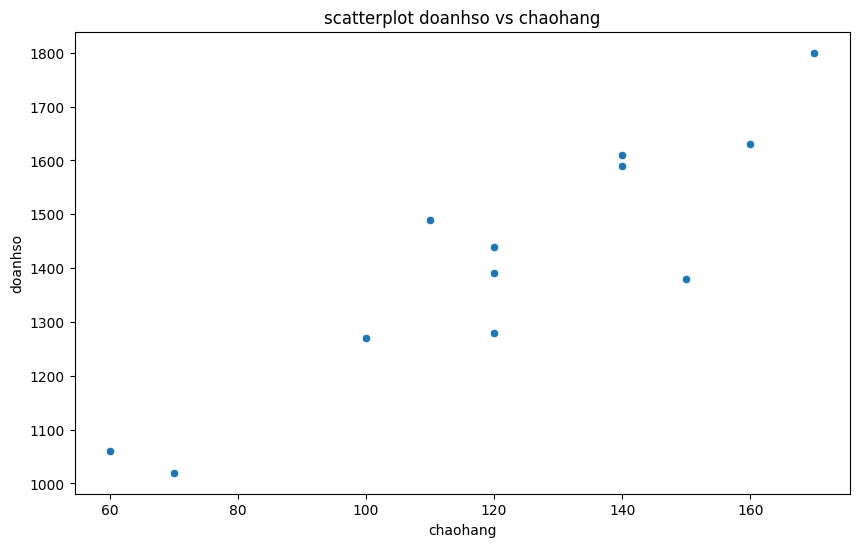

In [7]:
# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=table, x=f'{x.name}', y=f'{y.name}')

# Add labels and title
plt.xlabel(f'{x.name}')
plt.ylabel(f'{y.name}')
plt.title(f'scatterplot {y.name} vs {x.name}')

# Save the plot as an image file
plt.savefig(f'scatter plot {y.name} and {x.name}.png')

# Show the plot
plt.show()

**Kolmogorov-Smirnow test to see if the data is normally distributed:**
- If the data is normal distribution, use Pearson Correlation.
- If the data is not normal distribution, use Spearman Correlation.

In [8]:
# Perform the Kolmogorov-Smirnov test for normality on 'x' and 'y'
ks_statistic_x, p_value_x = kstest(x, 'norm', args=(x.mean(), x.std()))
ks_statistic_y, p_value_y = kstest(y, 'norm', args=(y.mean(), y.std()))

# Create the Kolmogorov-Smirnov test results table for 'x'
ks_test_results_x = pd.DataFrame({
  'Variable': ['x'],
  'KS Statistic': [ks_statistic_x],
  'p-value': [p_value_x],
  'alpha': [alpha],
  'Result': ['Reject the null hypothesis (data does not follow normal distribution)' if p_value_x <= alpha else 'Fail to reject the null hypothesis (data follows normal distribution)']
})

# Create the Kolmogorov-Smirnov test results table for 'y'
ks_test_results_y = pd.DataFrame({
  'Variable': ['y'],
  'KS Statistic': [ks_statistic_y],
  'p-value': [p_value_y],
  'alpha': [alpha],
  'Result': ['Reject the null hypothesis (data does not follow normal distribution)' if p_value_y <= alpha else 'Fail to reject the null hypothesis (data follows normal distribution)']
})

# Results for Test
if p_value_x > alpha and p_value_y > alpha:
  result_ks = 'Data follow normal distribution. Chose Pearson Correlation'
  conclusion_ks = pd.DataFrame({
    'Result': [result_ks]
  })
else:
  result_ks = 'Data does not follow normal distribution. Chose Spearman Correlation'
  conclusion_ks = pd.DataFrame({
    'Result': [result_ks]
  })

print('Kolmogorov-Smirnov Test Results for x:')
print(ks_test_results_x)
print()

print('Kolmogorov-Smirnov Test Results for y:')
print(ks_test_results_y)
print()

print('Conclusion:')
print(conclusion_ks)

# Lưu kết quả vào file Excel
with pd.ExcelWriter('simple_linear_regression_ks_test_results.xlsx') as writer:
  ks_test_results_x.to_excel(writer, sheet_name=f'KS Test Results {x.name}', index=False)
  ks_test_results_y.to_excel(writer, sheet_name=f'KS Test Results {y.name}', index=False)
  conclusion_ks.to_excel(writer, sheet_name='Conclusion', index=False)

print('Read file simple_linear_regression_ks_test_results.xlsx')

Kolmogorov-Smirnov Test Results for x:
  Variable  KS Statistic   p-value  alpha                                             Result
0        x      0.146845  0.925214   0.05  Fail to reject the null hypothesis (data follo...

Kolmogorov-Smirnov Test Results for y:
  Variable  KS Statistic   p-value  alpha                                             Result
0        y      0.110075  0.995062   0.05  Fail to reject the null hypothesis (data follo...

Conclusion:
                                              Result
0  Data follow normal distribution. Chose Pearson...
Read file simple_linear_regression_ks_test_results.xlsx


**Calculator r (Correlation Coefficient)**
* Pearson - dữ liệu có phân phối chuẩn.
* Spearman - dữ liện không cần phân phối chuẩn.

In [9]:
# Tính hệ số tương quan Pearson
pearson_corr, pearson_p_value = pearsonr(x, y)

# Tạo bảng tương quan Pearson
pearson_corr_df = pd.DataFrame({
  'Variable 1': [f'{x.name}'],
  'Variable 2': [f'{y.name}'],
  'Pearson Correlation': [pearson_corr],
  'p-value': [pearson_p_value]
})
print('Pearson Correlation:')
print(pearson_corr_df)
print()

# Conclusion based on Pearson correlation coefficient
if abs(pearson_corr) >= 0.7:
  correlation_strength = "strong"
elif 0.3 <= abs(pearson_corr) < 0.7:
  correlation_strength = "moderate"
else:
  correlation_strength = "weak"

if pearson_p_value < alpha:
  significance = "significant"
else:
  significance = "not significant"

conclusion_pearson = f"r Pearson: The correlation between {x.name} and {y.name} is {correlation_strength} and {significance}."

print(conclusion_pearson)
print()

# Tính hệ số tương quan Spearman
spearman_corr, spearman_p_value = spearmanr(x, y)

# Tạo bảng tương quan Spearman
spearman_corr_df = pd.DataFrame({
  'Variable 1': [f'{x.name}'],
  'Variable 2': [f'{y.name}'],
  'Spearman Correlation': [spearman_corr],
  'p-value': [spearman_p_value]
})
print('Spearman Correlation:')
print(spearman_corr_df)
print()

# Conclusion based on Spearman correlation coefficient
if abs(spearman_corr) >= 0.7:
  correlation_strength_spearman = "strong"
elif 0.3 <= abs(spearman_corr) < 0.7:
  correlation_strength_spearman = "moderate"
else:
  correlation_strength_spearman = "weak"

if spearman_p_value < alpha:
  significance_spearman = "significant"
else:
  significance_spearman = "not significant"

conclusion_spearman = f"r Spearman: The correlation between {x.name} and {y.name} is {correlation_strength_spearman} and {significance_spearman}."

print(conclusion_spearman)

conclusion = pd.DataFrame({
  'Result Pearson Correlation': [conclusion_pearson],
  'Result Spearman Correlation': [conclusion_spearman],
  'Chose Test Type':[result_ks]
})

print(result_ks)
print()

# Lưu kết quả vào file Excel
with pd.ExcelWriter('simple_linear_regression_correlation_coefficient_results.xlsx') as writer:
  pearson_corr_df.to_excel(writer, sheet_name='Pearson Correlation', index=False)
  spearman_corr_df.to_excel(writer, sheet_name='Spearman Correlation', index=False)
  conclusion.to_excel(writer, sheet_name='Conclusion', index=False)

  # Access the XlsxWriter workbook and worksheet objects
  workbook  = writer.book
  worksheet = workbook.add_worksheet('Bar Plot')

  # Insert the image into the worksheet
  worksheet.insert_image('A1', f'scatterplot {y.name} and {x.name}.png')

print('Read file simple_linear_regression_correlation_coefficient_results.xlsx')

Pearson Correlation:
  Variable 1 Variable 2  Pearson Correlation   p-value
0   chaohang    doanhso             0.904627  0.000053

r Pearson: The correlation between chaohang and doanhso is strong and significant.

Spearman Correlation:
  Variable 1 Variable 2  Spearman Correlation   p-value
0   chaohang    doanhso              0.821901  0.001038

r Spearman: The correlation between chaohang and doanhso is strong and significant.
Data follow normal distribution. Chose Pearson Correlation

Read file simple_linear_regression_correlation_coefficient_results.xlsx


/usr/local/lib/python3.10/dist-packages/xlsxwriter/worksheet.py:1534: UserWarning: Image file 'scatterplot doanhso and chaohang.png' not found.
  warn("Image file '%s' not found." % filename)


## 4.1.4 Simple linear regression

                            OLS Regression Results                            
Dep. Variable:                doanhso   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     45.05
Date:                Sat, 11 Jan 2025   Prob (F-statistic):           5.29e-05
Time:                        06:21:17   Log-Likelihood:                -71.636
No. Observations:                  12   AIC:                             147.3
Df Residuals:                      10   BIC:                             148.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    651.5229    117.384      5.550      0.0

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  res = hypotest_fun_out(*samples, **kwds)


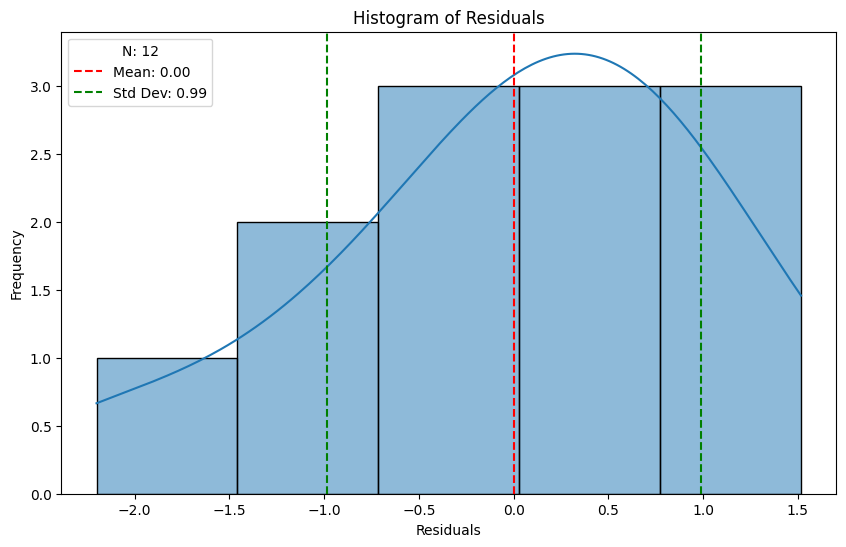

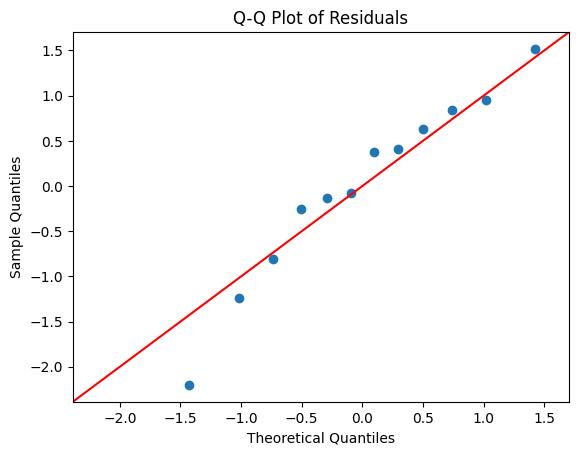

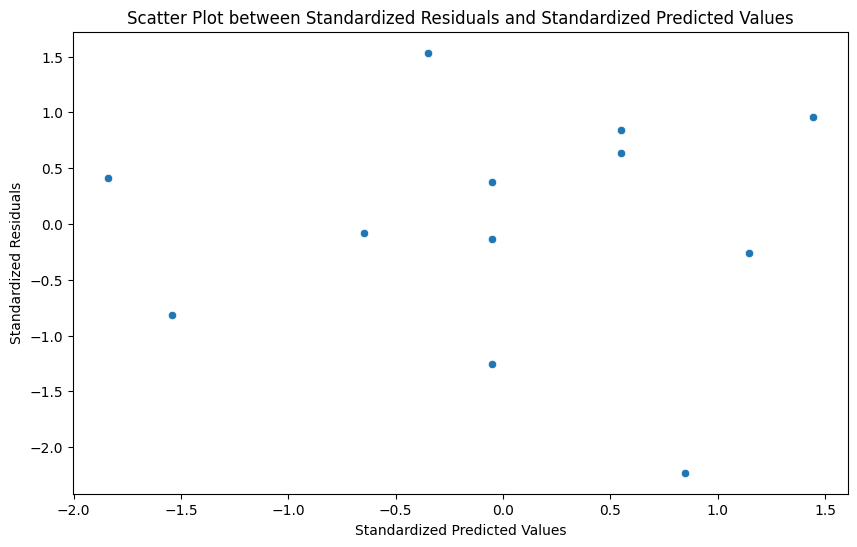

Read file simple_linear_regression_results.xlsx


In [10]:
# Tạo mô hình hồi quy tuyến tính sử dụng công thức
model = smf.ols(f'{y.name} ~ {x.name}', data=table).fit()
print(model.summary())
print()

# Kiểm định Durbin-Watson
residuals = model.resid
residuals_test = abs(residuals)
durbin_watson = sm.stats.stattools.durbin_watson(residuals)

standardized_residuals = model.get_influence().resid_studentized_internal

# Redesign the model_summary table
model_summary = pd.DataFrame({
  'Date': [model.summary2().tables[0].iloc[2, 1]],
  'Model': ['OLS'],
  'Dependent Variable': [model.summary2().tables[0].iloc[1, 1]],
  'R-squared': [model.rsquared],
  'Adj. R-squared': [model.rsquared_adj],
  'Durbin Watson': [durbin_watson]
})
print('Model Summary:')
print(model_summary.to_string())
print()

# Bảng ANOVA
anova_table = sm.stats.anova_lm(model, typ=2, robust='hc3')
# Calculate the total sum of squares (SST)
sst = sum((y - y.mean()) ** 2)
# Calculate the residual sum of squares (SSE)
sse = sum(residuals ** 2)
# Calculate the regression sum of squares (SSR)
ssr_regression = sst - sse
# Calculate total sum of squares
ssr_residual = anova_table['sum_sq']['Residual']
# Calculate reression sum of squares
ssr_total = ssr_regression + ssr_residual
# Degrees of freedom
df_residual = model.summary().tables[0][6][1].data
df_regression = model.summary().tables[0][7][1].data
df_total = pd.to_numeric(df_regression, errors='coerce') + pd.to_numeric(df_residual, errors='coerce')
# F-statistic and p-value
f_statistic = pd.to_numeric(model.summary().tables[0][2][3].data, errors='coerce')
anova_p_value = pd.to_numeric(model.summary().tables[0][3][3].data, errors='coerce')
# Create the ANOVA table
anova_table = pd.DataFrame({
  'Source': ['Regression', 'Residual', 'Total'],
  'sum_sq': [ssr_regression, ssr_residual, ssr_total],
  'df': [df_regression, df_residual, df_total],
  'F': [f_statistic, None, None],
  'PR(>F)': [anova_p_value, None, None]
})
print('ANOVA table')
print(anova_table)
print()

# Bảng Coefficients
coefficients = model.summary2().tables[1]
print('Coefficients:')
print(coefficients)
print()

# Bảng Correlations - Kiểm định Spearman cho 2 biến x và abs(residuals) (kiểm định giả định phương sai của sai số không đổi)
spearman_corr, spearman_p_value = spearmanr(x, residuals_test)

# Conclusion based on Spearman correlation coefficient
if abs(spearman_corr) >= 0.7:
  correlation_strength_spearman = "strong"
elif 0.3 <= abs(spearman_corr) < 0.7:
  correlation_strength_spearman = "moderate"
else:
  correlation_strength_spearman = "weak"

if spearman_p_value < alpha:
  significance_spearman = "significant"
else:
  significance_spearman = "not significant"

conclusion_spearman = f"r Spearman: The correlation between {x.name} and residuals is {correlation_strength_spearman} and {significance_spearman}."

# Tạo bảng tương quan Spearman
spearman_corr_df = pd.DataFrame({
  'Variable 1': [f'{x.name}'],
  'Variable 2': ['residuals'],
  'Spearman Correlation': [spearman_corr],
  'p-value': [spearman_p_value],
  'Conclusion': [conclusion_spearman]
})

# Kiểm định F - Kiểm tra Sig (p-value) bảng Anova
anova_result = 'Model is significant' if anova_p_value < alpha else 'Model is not significant'
print(f"ANOVA p-value: {anova_p_value}, Result: {anova_result}")
print()

# Đánh giá Adj. R-squared
adj_r_squared = model.rsquared_adj
adj_r_squared_result = 'Model fits well' if adj_r_squared > 0.7 else 'Model fits moderate' if 0.5 < adj_r_squared <= 0.7 else 'Model does not fit'
print(f"Adjusted R-squared: {adj_r_squared}, Result: {adj_r_squared_result}")
print()

# Kiểm định Durbin–Watson
durbin_watson_result = 'No autocorrelation' if 1.5 < durbin_watson < 2.5 else 'Autocorrelation present'
print(f"Durbin-Watson: {durbin_watson}, Result: {durbin_watson_result}")
print()

# Kiểm định t (student) - Kiểm tra Sig (p-value) từng biến độc lập bảng Coefficients
coefficients_p_values = coefficients.loc[f'{x.name}','P>|t|']
coefficients_result = 'Independent variable is fit' if coefficients_p_values < alpha else 'Independent variable is not fit'
print(f"p_values Independent variable: {coefficients_p_values}, Result: {coefficients_result}")
print()

# Predict the values using the regression model
predicted_values = model.predict(table)
# Calculate MSE
mse = np.mean((y - predicted_values)**2)
# Calculate RMSE
rmse = np.sqrt(mse)

# Evaluation
if mse < 10 : # example threshold, adjust as needed
    mse = "The model's Mean Squared Error (MSE) is relatively low, suggesting good fit."
else:
    mse = "The model's Mean Squared Error (MSE) is high, indicating poor fit. Consider model improvement."
if rmse < 3: # example threshold, adjust as needed
    rmse = "The model's Root Mean Squared Error is relatively low, suggesting accurate predictions."
else:
    rmse = "The model's Root Mean Squared Error is high, suggesting inaccurate predictions. Consider model improvement."
print('Đánh giá MSE và RMSE:')
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print()

hypothesis_test = pd.DataFrame({
  'Đánh giá Adj. R-squared': [f'Adjusted R-squared: {adj_r_squared}, Result: {adj_r_squared_result}'],
  'Kiểm định F': [f'ANOVA p-value: {anova_p_value}, Result: {anova_result}'],
  'Kiểm định t (student)': [f'Coefficients_p_values: {coefficients_p_values}, Result: {coefficients_result}'],
  'Kiểm định Durbin-Watson': [f'Durbin-Watson: {durbin_watson}, Result: {durbin_watson_result}'],
  'kiểm định giả định phương sai của sai số không đổi': [conclusion_spearman],
  'mse': [mse],
  'rmse': [rmse]
})
hypothesis_test = hypothesis_test.melt(var_name='Test', value_name='Result')
print('Hypothsis Test:')
print(hypothesis_test)
print()

# Lấy hệ số từ bảng coefficients
intercept = coefficients.loc['Intercept', 'Coef.']
slope = coefficients.loc[f'{x.name}', 'Coef.']
regression_equation = f'y = {intercept:.2f} + {slope:.2f} * x'
print('Simple Linear Regression')
print(regression_equation)
print()

# Viết phương trình hồi quy tuyến tính đơn
regression_equation = pd.DataFrame({
  'Function': [regression_equation]
})

# Biểu đồ Histogram để khảo sát phân phối của phần dư
# Calculate mean, standard deviation, and sample size
mean_residuals = standardized_residuals.mean()
std_dev_residuals = standardized_residuals.std()
N_residuals = len(standardized_residuals)
plt.figure(figsize=(10, 6))
sns.histplot(standardized_residuals, kde=True)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
# Add mean, standard deviation, and sample size to the plot
plt.axvline(mean_residuals, color='r', linestyle='--', label=f'Mean: {mean_residuals:.2f}')
plt.axvline(mean_residuals + std_dev_residuals, color='g', linestyle='--', label=f'Std Dev: {std_dev_residuals:.2f}')
plt.axvline(mean_residuals - std_dev_residuals, color='g', linestyle='--')
plt.legend(title=f'N: {N_residuals}')
plt.savefig('histogram_of_residuals.png')
plt.show()
print()

# Biểu đồ Q-Q plot để khảo sát phân phối của phần dư
sm.qqplot(standardized_residuals, line='45')
plt.title('Q-Q Plot of Residuals')
plt.savefig('qq_plot_of_residuals.png')
plt.show()
print()

# Standardize the residuals and predicted values
standardized_residuals = (standardized_residuals - standardized_residuals.mean()) / standardized_residuals.std()
standardized_predicted = (model.fittedvalues - model.fittedvalues.mean()) / model.fittedvalues.std()
# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=standardized_predicted, y=standardized_residuals)
# Add labels and title
plt.xlabel('Standardized Predicted Values')
plt.ylabel('Standardized Residuals')
plt.title('Scatter Plot between Standardized Residuals and Standardized Predicted Values')
plt.savefig('scatterplot_standardized_residuals_vs_predicted.png')
plt.show()

# Lưu kết quả vào file Excel
with pd.ExcelWriter('simple_linear_regression_results.xlsx') as writer:
  anova_table.to_excel(writer, sheet_name='ANOVA')
  model_summary.to_excel(writer, sheet_name='Model Summary')
  coefficients.to_excel(writer, sheet_name='Coefficients')
  spearman_corr_df.to_excel(writer, sheet_name='Correlations', index=False)
  regression_equation.to_excel(writer, sheet_name='Function', index=False)
  hypothesis_test.to_excel(writer, sheet_name='Hypothesis Test', index=False)
  # Access the XlsxWriter workbook and worksheet objects
  workbook  = writer.book
  worksheet = workbook.add_worksheet('Residuals Plots')

  # Insert the images into the worksheet
  worksheet.insert_image('A1', 'histogram_of_residuals.png')
  worksheet.insert_image('A10', 'qq_plot_of_residuals.png')
  worksheet.insert_image('A20', 'scatterplot_standardized_residuals_vs_predicted.png')

print('Read file simple_linear_regression_results.xlsx')

## 4.1.5 Predict the values using the regression model

In [11]:
# Predict the values using the regression model
predicted_values = model.predict(table)

# Add the predicted values to the dataframe
table['predicted_values'] = predicted_values

# Display the dataframe with the predicted values
print(table[['chaohang', 'doanhso', 'predicted_values']])

    chaohang  doanhso  predicted_values
0        100     1270       1277.668464
1        110     1490       1340.283019
2         60     1060       1027.210243
3        160     1630       1653.355795
4         70     1020       1089.824798
5        170     1800       1715.970350
6        140     1610       1528.126685
7        120     1280       1402.897574
8        120     1390       1402.897574
9        120     1440       1402.897574
10       140     1590       1528.126685
11       150     1380       1590.741240


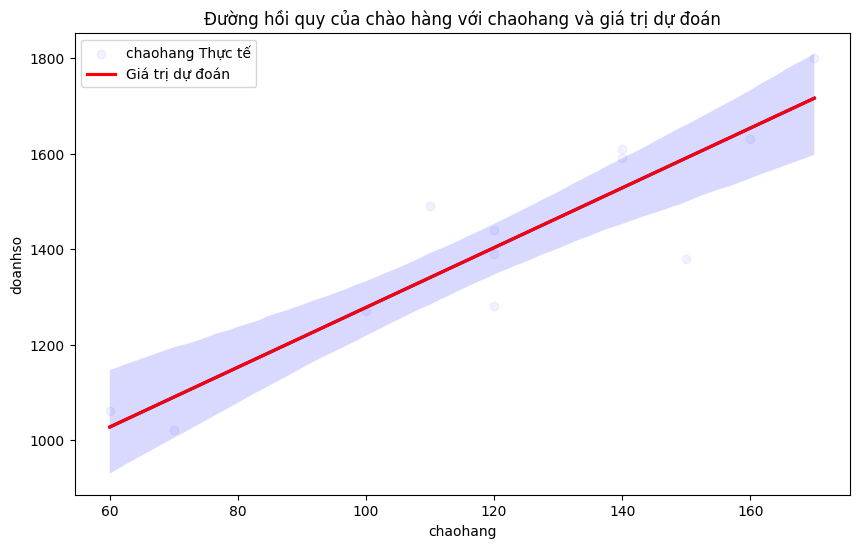

In [12]:
# Create the plot
plt.figure(figsize=(10, 6))
sns.regplot(x=f'{x.name}', y=f'{y.name}', data=table, label=f'{x.name} Thực tế', scatter_kws={'alpha': alpha}, color='blue')
sns.regplot(x=f'{x.name}', y='predicted_values', data=table, label='Giá trị dự đoán', scatter=False, color='red')

plt.xlabel(f'{x.name}')
plt.ylabel(f'{y.name}')
plt.title(f'Đường hồi quy của chào hàng với {x.name} và giá trị dự đoán')
plt.legend()
plt.show()

**Define the value of x for which you want to predict y**

In [13]:
# Define the value of x for which you want to predict y
x_value = 120

# Create a DataFrame with the new value
new_data = pd.DataFrame({x.name: [x_value]})

# Predict the doanhso value using the regression model
predicted_doanhso = model.predict(new_data)

# Display the predicted value
print(f'Predicted {y.name} for {x.name} = {x_value}: {predicted_doanhso.iloc[0]}')

Predicted doanhso for chaohang = 120: 1402.897574123989


# 4.2 Multiple Linear Regression

## 4.2.1 Input Data

In [14]:
# File path to your .sav file
file_path = "/content/drive/My Drive/Colab Notebooks/Data/Hoi quy boi.csv"

# Read the SPSS file
hqb = pd.read_csv(file_path).drop(columns=['id'])

## 4.2.2 Input Test Value

In [15]:
# Input Data
table = hqb
# Input the dependent variable
dependent_var = 'ttxang'

# Define the independent variables
independent_vars = table.columns.drop(dependent_var).tolist()
# Define the confidence interval
confidence_interval = 0.95
z_value = norm.ppf((1 + confidence_interval) / 2)
alpha = round(1 - confidence_interval, 3)

  
## 4.2.3 Correlation Coefficient

Ma trân hệ số tương quan. Đo lường mỗi quan hệ giữa các cặp biến.
- Biến phụ thuộc và độc lập tương quan mạnh - Hồi quy tốt.
- Biến phụ thuộc tương quan với nhau mạnh - Dự đoán khả năng đa cộng tuyến cao.

- Dependent - ttxang (Mức độ tiêu thụ xăng)
- Independent - nang (Trọng lượng xe), maluc (Công suất xe), may (Số máy), lit (Dung tích động cơ của xe)

Read file multiple_linear_regression_correlation_coefficient_results.xlsx


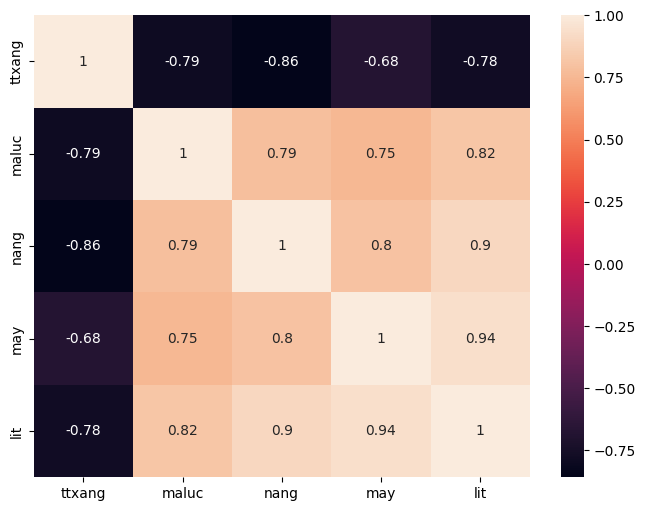

In [16]:
# Calculate the correlation matrix
correlation_matrix = table.corr()

# Save the correlation matrix to an Excel file
correlation_matrix.to_excel('multiple_linear_regression_correlation_coefficient_results.xlsx')

#Correlation Heatmap (print the correlation score each variables)
plt.figure(figsize=(8, 6))
sns.heatmap(table.corr(), fmt='.2g', annot=True)

print('Read file multiple_linear_regression_correlation_coefficient_results.xlsx')

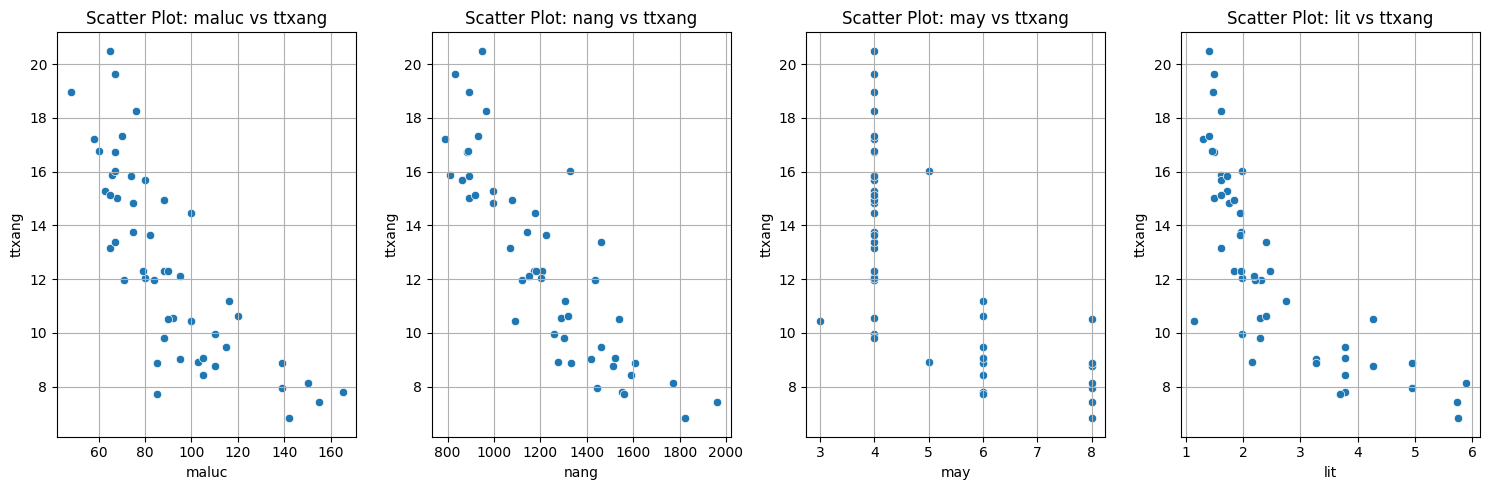

In [17]:
# Biểu đồ phân tán cho từng biến độc lập
num_plots = len(independent_vars)
cols = 4  # Number of columns in the subplot grid
rows = (num_plots + cols - 1) // cols  # Calculate the number of rows needed

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))  # Adjust figsize as needed
axes = axes.ravel()  # Flatten the axes array for easier iteration


for i, col in enumerate(independent_vars):
    sns.scatterplot(x=col, y=dependent_var, data=table, ax=axes[i])
    axes[i].set_title(f'Scatter Plot: {col} vs {dependent_var}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel(f'{dependent_var}')
    axes[i].grid(True)

# Hide any unused subplots
for j in range(i + 1, rows * cols):
    fig.delaxes(axes[j])

plt.tight_layout()  # Adjust layout to prevent overlapping titles/labels
plt.show()

## 4.2.4 Multiple Linear Regression

                            OLS Regression Results                            
Dep. Variable:                 ttxang   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.757
Method:                 Least Squares   F-statistic:                     39.08
Date:                Sat, 11 Jan 2025   Prob (F-statistic):           4.23e-14
Time:                        06:21:26   Log-Likelihood:                -96.970
No. Observations:                  50   AIC:                             203.9
Df Residuals:                      45   BIC:                             213.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     26.2335      2.319     11.312      0.0

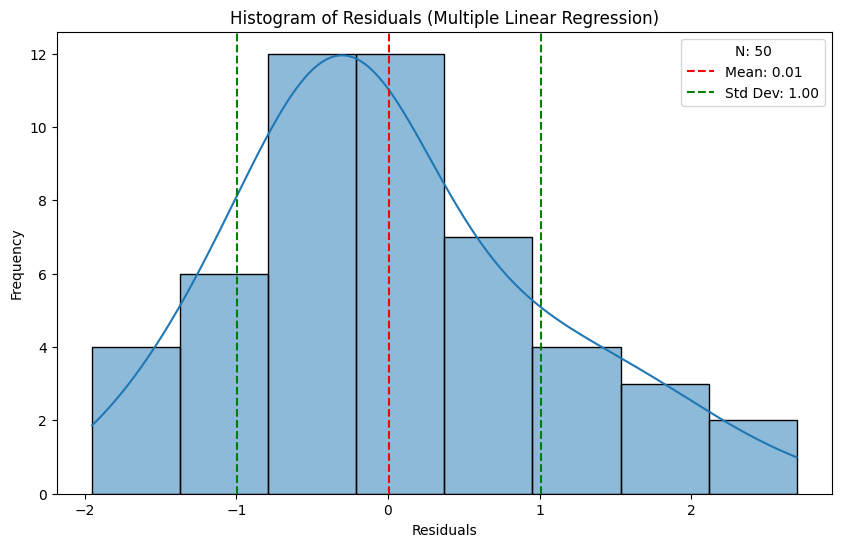

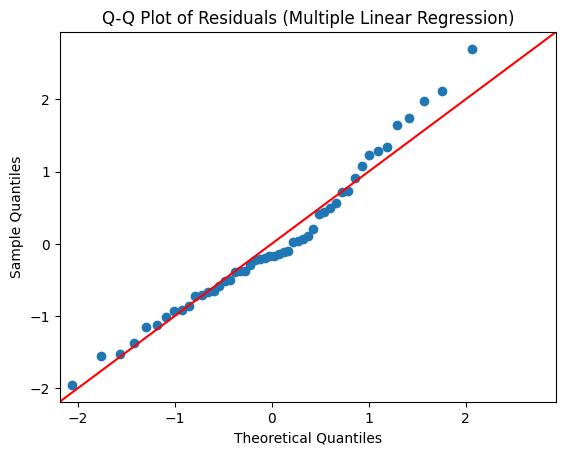

Read file multiple_linear_regression_results.xlsx


In [18]:
# Tạo mô hình hồi quy tuyến tính bội sử dụng công thức
# Create the formula for the regression model
formula = f"{dependent_var} ~ {' + '.join(independent_vars)}"
# Create the multiple linear regression model using the formula
model_multiple = smf.ols(formula, data=table).fit()
print(model_multiple.summary())
print()

# Kiểm định Durbin-Watson
residuals_multiple = model_multiple.resid
durbin_watson_multiple = sm.stats.stattools.durbin_watson(residuals_multiple)

# Redesign the model_summary table
model_summary_multiple = pd.DataFrame({
  'Date': [model_multiple.summary2().tables[0].iloc[2, 1]],
  'Model': ['OLS'],
  'Dependent Variable': [model_multiple.summary2().tables[0].iloc[1, 1]],
  'R-squared': [model_multiple.rsquared],
  'Adj. R-squared': [model_multiple.rsquared_adj],
  'Durbin Watson': [durbin_watson_multiple]
})
print('Model Summary:')
print(model_summary_multiple)
print()

# Bảng ANOVA
anova_table_multiple = sm.stats.anova_lm(model_multiple, typ=2, robust='hc3')
# Calculate total sum of squares
total_sum_squares = sum((table[dependent_var] - table[dependent_var].mean())**2)
# Calculate regression sum of squares
regression_sum_squares = total_sum_squares - anova_table_multiple['sum_sq']['Residual']
# Degrees of freedom
df_regression = model_multiple.summary().tables[0][6][1].data
df_residual = model_multiple.summary().tables[0][7][1].data
df_total = pd.to_numeric(df_regression, errors='coerce') + pd.to_numeric(df_residual, errors='coerce')
# F-statistic and p-value
f_statistic = pd.to_numeric(model_multiple.summary().tables[0][2][3].data, errors='coerce')
p_value = pd.to_numeric(model_multiple.summary().tables[0][3][3].data, errors='coerce')
# Create the ANOVA table
anova_table_multiple = pd.DataFrame({
  'Source': ['Regression', 'Residual', 'Total'],
  'sum_sq': [regression_sum_squares, anova_table_multiple['sum_sq']['Residual'], total_sum_squares],
  'df': [df_regression, df_residual, df_total],
  'F': [f_statistic, None, None],
  'PR(>F)': [p_value, None, None]
})
print('ANOVA Table:')
print(anova_table_multiple)
print()

# Bảng Coefficients
coefficients_multiple = model_multiple.summary2().tables[1]
# Calculate the standardized coefficients (beta)
standardized_coefficients = model_multiple.params * (table[independent_vars].std() / table[dependent_var].std())
# Add the standardized coefficients to the coefficients table
coefficients_multiple['Standardized Coef.'] = standardized_coefficients
# Calculate VIF for each independent variable
vif_data = pd.DataFrame()
vif_data["Variable"] = independent_vars
vif_data["VIF"] = [variance_inflation_factor(table[independent_vars].values, i) for i in range(len(independent_vars))]
# Add the VIP column to the coefficients_multiple dataframe
coefficients_multiple = coefficients_multiple.merge(vif_data, how='left', left_index=True, right_on='Variable')
# Rearrange the columns
coefficients_multiple = coefficients_multiple[['Variable', 'Coef.', 'Std.Err.', 'Standardized Coef.', 't', 'P>|t|', '[0.025', '0.975]', 'VIF']]
print('Coefficients:')
print(coefficients_multiple)
print()

# Đánh giá Adj. R-squared
adj_r_squared = model_multiple.rsquared_adj
adj_r_squared_result = 'Model fits well' if adj_r_squared > 0.7 else 'Model fits moderate' if 0.5 < adj_r_squared <= 0.7 else 'Model does not fit'
print('Đánh giá Adj. R-squared:')
print(adj_r_squared_result)
print()

# Kiểm định F - Kiểm tra Sig (p-value) bảng ANOVA
anova_p_value = anova_table_multiple.loc[0, 'PR(>F)']
anova_result = 'Model is significant' if anova_p_value < alpha else 'Model is not significant'
print('Kiểm định F - Kiểm tra Sig (p-value) bảng ANOVA:')
print(anova_result)
print()

# Kiểm định Durbin–Watson
durbin_watson_result = 'No autocorrelation' if 1.5 < durbin_watson_multiple < 2.5 else 'Autocorrelation present'
print('Kiểm định Durbin–Watson:')
print(durbin_watson_result)
print()

# Kiểm định t (student) - Kiểm tra Sig (p-value) từng biến độc lập bảng Coefficients
coefficients_p_values = coefficients_multiple['P>|t|']
# Check the significance of each independent variable excluding 'Intercept'
significant_vars = coefficients_multiple[(coefficients_multiple['P>|t|'] < alpha) & (coefficients_multiple['Variable'] != 'Intercept')]
non_significant_vars = coefficients_multiple[(coefficients_multiple['P>|t|'] >= alpha) & (coefficients_multiple['Variable'] != 'Intercept')]
if significant_vars is None and non_significant_vars is not None:
  result_t_test = f"Non-significant variables: {', '.join(non_significant_vars['Variable'].dropna())}"
elif significant_vars is not None and non_significant_vars is None:
  result_t_test = f"Significant variables: {', '.join(significant_vars['Variable'].dropna())}"
else:
  result_t_test = f"Significant variables: {', '.join(significant_vars['Variable'].dropna())} AND Non-significant variables: {', '.join(non_significant_vars['Variable'].dropna())}"
print('Kiểm định t (student):')
print(result_t_test)
print()

# Check for multicollinearity using VIF
multicollinearity_vars = vif_data[vif_data['VIF'] > 10]
if not multicollinearity_vars.empty:
  multicollinearity_result = "There is a possibility of multicollinearity"
else:
  multicollinearity_result = "The model is suitable as all variables meet the VIF criteria"
print('Check for multicollinearity:')
print(multicollinearity_result)
print()

# Predict the values using the regression model
predicted_values = model_multiple.predict(table) # Prediction using model_multiple
# Add the predicted values to the dataframe
table['predicted_values'] = predicted_values # Adding the column to 'table'
# Calculate MSE using NumPy
mse = np.mean((table[dependent_var] - table['predicted_values'])**2)
# Calculate RMSE
rmse = np.sqrt(mse)
# Evaluate MSE and RMSE
if mse < 10 : # example threshold, adjust as needed
  mse = "The model's Mean Squared Error (MSE) is relatively low, suggesting good fit."
else:
  mse = "The model's Mean Squared Error (MSE) is high, indicating poor fit. Consider model improvement."
if rmse < 3: # example threshold, adjust as needed
  rmse = "The model's Root Mean Squared Error is relatively low, suggesting accurate predictions."
else:
  rmse = "The model's Root Mean Squared Error is high, suggesting inaccurate predictions. Consider model improvement."
print('Đánh giá MSE và RMSE:')
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print()

# Kiểm tra nếu có điểm nào không đạt yêu cầu
if adj_r_squared_result != 'Model fits well' or anova_result != 'Model is significant' or durbin_watson_result != 'No autocorrelation' or multicollinearity_result != 'The model is suitable as all variables meet the VIF criteria' or {', '.join(non_significant_vars['Variable'].dropna())} == '' in result_t_test:
  conclusion = "Should Optimized Model"
else:
  conclusion = "Model Meets Requirements"
print('Đánh giá tổng hợp:')
print(conclusion)
print()

# Tạo bảng hypothesis_test
hypothesis_test = pd.DataFrame({
  'Đánh giá Adj. R-squared': [f'Adjusted R-squared: {adj_r_squared:.3f}, Result: {adj_r_squared_result}'],
  'Kiểm định F': [f'ANOVA p-value: {anova_p_value:.3e}, Result: {anova_result}'],
  'Kiểm định t (student)': [result_t_test],
  'Kiểm định Durbin-Watson': [f'Durbin-Watson: {durbin_watson_multiple:.3f}, Result: {durbin_watson_result}'],
  'Kiểm định VIP': [multicollinearity_result],
  'mse': [mse],
  'rmse': [rmse],
  'Conclusion': [conclusion]
})
hypothesis_test = hypothesis_test.melt(var_name='Test', value_name='Result')

# Viết phương trình hồi quy
intercept = coefficients_multiple.loc[coefficients_multiple['Variable'] == 'Intercept', 'Coef.'].values[0]
slopes = coefficients_multiple.loc[coefficients_multiple['Variable'] != 'Intercept', ['Variable', 'Coef.']]
regression_equation = f'y = {intercept:.2f}'
for index, row in slopes.iterrows():
  regression_equation += f' + {row["Coef."]:.2f} * {row["Variable"]}'
  regression_equation = f'y = {intercept:.2f}'
  for index, row in slopes.iterrows():
    coef = row["Coef."]
    variable = row["Variable"]
    sign = '+' if coef >= 0 else '-'
    regression_equation += f' {sign} {abs(coef):.2f} * {variable}'
print('Regression Equation:')
print(regression_equation)
print()

# Tạo bảng phương trình hồi quy
regression_equation_df = pd.DataFrame({
  'Function': [regression_equation],
  'Conclusion': [conclusion]
})

# Biểu đồ Histogram để khảo sát phân phối của phần dư
standardized_residuals_multiple = model_multiple.get_influence().resid_studentized_internal
mean_residuals_multiple = standardized_residuals_multiple.mean()
std_dev_residuals_multiple = standardized_residuals_multiple.std()
N_residuals_multiple = len(standardized_residuals_multiple)
plt.figure(figsize=(10, 6))
sns.histplot(standardized_residuals_multiple, kde=True)
plt.title('Histogram of Residuals (Multiple Linear Regression)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.axvline(mean_residuals_multiple, color='r', linestyle='--', label=f'Mean: {mean_residuals_multiple:.2f}')
plt.axvline(mean_residuals_multiple + std_dev_residuals_multiple, color='g', linestyle='--', label=f'Std Dev: {std_dev_residuals_multiple:.2f}')
plt.axvline(mean_residuals_multiple - std_dev_residuals_multiple, color='g', linestyle='--')
plt.legend(title=f'N: {N_residuals_multiple}')
plt.savefig('histogram_of_residuals_multiple.png')
plt.show()
print()

# Biểu đồ Q-Q plot để khảo sát phân phối của phần dư
sm.qqplot(standardized_residuals_multiple, line='45')
plt.title('Q-Q Plot of Residuals (Multiple Linear Regression)')
plt.savefig('qq_plot_of_residuals_multiple.png')
plt.show()

# Lưu kết quả vào file Excel
with pd.ExcelWriter('multiple_linear_regression_results.xlsx') as writer:
  correlation_matrix.to_excel(writer, sheet_name='Corr Matrix')
  model_summary_multiple.to_excel(writer, sheet_name='Model Summary')
  anova_table_multiple.to_excel(writer, sheet_name='ANOVA')
  coefficients_multiple.to_excel(writer, sheet_name='Coefficients')
  hypothesis_test.to_excel(writer, sheet_name='Hypothesis Test', index=False)
  regression_equation_df.to_excel(writer, sheet_name='Regression Equation', index=False)
  # Access the XlsxWriter workbook and worksheet objects
  workbook  = writer.book
  worksheet = workbook.add_worksheet('Residuals Plots')

  # Insert the images into the worksheet
  worksheet.insert_image('A1', 'histogram_of_residuals_multiple.png')
  worksheet.insert_image('A10', 'qq_plot_of_residuals_multiple.png')

print('Read file multiple_linear_regression_results.xlsx')

## 4.2.5 Predict the values using the regression model

In [19]:
# Predict the values using the regression model
predicted_values = model_multiple.predict(table)

# Add the predicted values to the dataframe
table['predicted_values'] = predicted_values

# Get the column names of independent variables from the model
independent_vars = list(model_multiple.params.index)
independent_vars.remove('Intercept')

# Construct the column list for display, dynamically adding independent variable names
columns_to_display = independent_vars + ['predicted_values']
table[columns_to_display]
print(table)

# Example prediction for new data
# Define the value of independent variables for which you want to predict the dependent variable
new_data = pd.DataFrame({'nang': [1200], 'maluc': [80], 'may': [4], 'lit': [2.0]})
# Predict the dependent variable value using the regression model
predicted_ttxang = model_multiple.predict(new_data)
# Display the predicted value
print(f'Predicted ttxang for nang=1200, maluc=80, may=4, lit=2.0: {predicted_ttxang.iloc[0]}')

    ttxang  maluc  nang  may      lit  predicted_values
0   18.964     48   893    4  1.47510         17.146037
1    8.756    110  1514    8  4.26140         10.125500
2    8.448    105  1591    6  3.78609          9.081341
3    7.788    165  1550    6  3.78609          6.703078
4    7.964    139  1442    8  4.94978          9.573647
5    8.932    103  1274    5  2.14709         11.521082
6    9.460    115  1460    6  3.78609          9.814780
7    7.436    155  1962    8  5.73650          4.248739
8    6.820    142  1824    8  5.75289          6.103472
9    8.140    150  1773    8  5.90040          6.227004
10  11.968     71  1436    4  2.31099         11.299631
11  18.260     76   965    4  1.60622         15.230334
12  20.504     65   950    4  1.40954         15.836143
13  10.428    100  1089    3  1.14730         12.675627
14  11.968     84  1121    4  2.21265         13.552210
15  17.204     58   790    4  1.29481         17.592533
16  12.320     88  1172    4  1.83568         12

## 4.2.6 Stepwise Selection
Sử dụng phương pháp chọn từng bước. Đưa vào dần và loại trừ dần để tìm model phù hợp.

In [20]:
# Define the dependent variable
y = table[dependent_var]

# Define the independent variables
X = table[independent_vars]

# Function to calculate VIF
def calculate_vif(X):
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    if X.shape[1] > 1:  # Check if there are more than 1 columns
        vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    else:
        vif["VIF"] = [np.nan]  # Assign NaN if only one column is present
    return vif

# Function to perform stepwise regression
def stepwise_selection(X, y, threshold_in=0.05, threshold_out=0.05):
    initial_features = X.columns.tolist()
    best_features = []
    model_details = []  # List to store details of each regression model

    while True:
        changed = False

        # Forward step
        remaining_features = list(set(initial_features) - set(best_features))
        new_pval = pd.Series(index=remaining_features)
        for new_column in remaining_features:
            model = sm.OLS(y, sm.add_constant(X[best_features + [new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]

            # Save model details
            model_details.append({
                'Features': best_features + [new_column],
                'AIC': model.aic,
                'BIC': model.bic,
                'R-squared': model.rsquared,
                'Adjusted R-squared': model.rsquared_adj
            })

        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_features.append(new_pval.idxmin())
            changed = True

        # Backward step
        model = sm.OLS(y, sm.add_constant(X[best_features])).fit()
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max()
        if worst_pval > threshold_out:
            changed = True
            worst_feature = pvalues.idxmax()
            best_features.remove(worst_feature)

        if not changed:
            break

    return best_features, model_details

# Perform stepwise regression
best_features, model_details = stepwise_selection(X, y)

# Print details of all regression models
print("All Models Details:")
for idx, details in enumerate(model_details, 1):
    print(f"Model {idx}:")
    print(f"Features: {details['Features']}")
    print(f"R-squared: {details['R-squared']:.4f}, Adjusted R-squared: {details['Adjusted R-squared']:.4f}") #AIC: {details['AIC']:.4f}, BIC: {details['BIC']:.4f},

    # Calculate VIF for the current model
    current_model_X = X[details['Features']]
    current_vif = calculate_vif(current_model_X)
    print(f"VIF for Model {idx}:")
    print(current_vif)
    print("-" * 40)
print()

# Filter for significant p-values and VIF < 10
filtered_models = []
for idx, details in enumerate(model_details):
    current_model_X = X[details["Features"]]
    current_vif = calculate_vif(current_model_X)

    # Check for VIF values less than 10 (excluding intercept if present)
    valid_vif = True
    if 'const' in current_vif['Variable'].values:
      current_vif = current_vif[current_vif['Variable'] != 'const']

    #Check if all VIF values are less than 10
    if len(current_vif) > 0 and current_vif['VIF'].max() >= 10:
        valid_vif = False

    if valid_vif:
        filtered_models.append(details)

# Find best model within filtered ones
best_model_filtered = None
best_r_squared = -1

for model in filtered_models:
    if model['R-squared'] > best_r_squared:
        best_r_squared = model['R-squared']
        best_model_filtered = model

print("Best Model after filtering by VIF < 10:")
if best_model_filtered:
    # print(best_model_filtered)
    #Fit the best model
    best_model = sm.OLS(y, sm.add_constant(X[best_model_filtered['Features']])).fit()
    print(best_model.summary())
    print()
    print("VIF for best model:")
    print(calculate_vif(X[best_model_filtered['Features']]))
else:
    print("No model found within VIF < 10")

All Models Details:
Model 1:
Features: ['lit']
R-squared: 0.6042, Adjusted R-squared: 0.5959
VIF for Model 1:
  Variable  VIF
0      lit  NaN
----------------------------------------
Model 2:
Features: ['may']
R-squared: 0.4639, Adjusted R-squared: 0.4528
VIF for Model 2:
  Variable  VIF
0      may  NaN
----------------------------------------
Model 3:
Features: ['nang']
R-squared: 0.7364, Adjusted R-squared: 0.7309
VIF for Model 3:
  Variable  VIF
0     nang  NaN
----------------------------------------
Model 4:
Features: ['maluc']
R-squared: 0.6212, Adjusted R-squared: 0.6133
VIF for Model 4:
  Variable  VIF
0    maluc  NaN
----------------------------------------
Model 5:
Features: ['nang', 'lit']
R-squared: 0.7365, Adjusted R-squared: 0.7253
VIF for Model 5:
  Variable        VIF
0     nang  13.863828
1      lit  13.863828
----------------------------------------
Model 6:
Features: ['nang', 'may']
R-squared: 0.7366, Adjusted R-squared: 0.7253
VIF for Model 6:
  Variable       VIF
0

## 4.2.7 Optimize Model

In [21]:
# independent_vars = [var for var in table.columns if var not in [dependent_var, 'maluc', 'may','lit','predicted_values']] #input dependent remove
independent_vars = best_model_filtered['Features']
dependent_var = dependent_var
print(independent_vars)
table_optimize = table[[dependent_var] + independent_vars] # Use combined_df
print(table_optimize.columns)

['nang']
Index(['ttxang', 'nang'], dtype='object')


Read file multiple_linear_regression_correlation_coefficient_results_1.xlsx


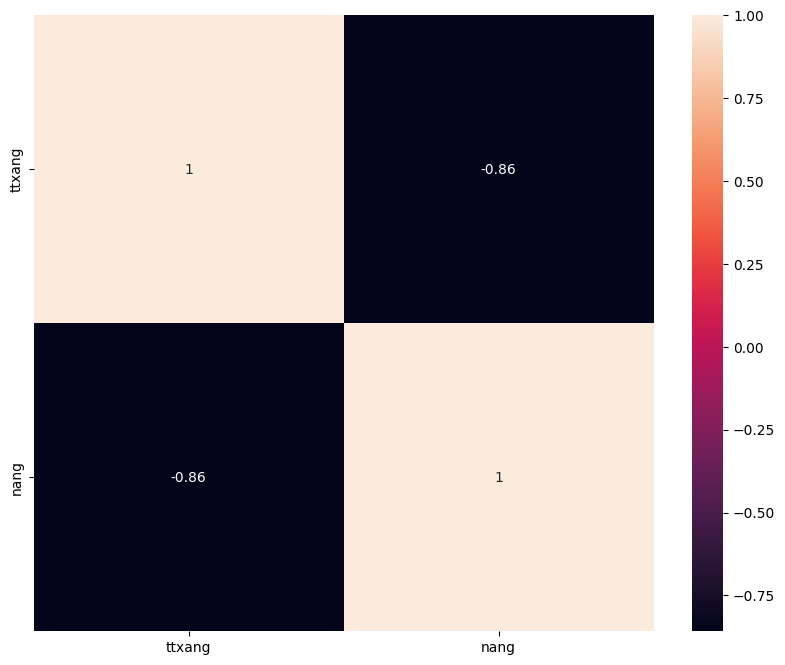

In [22]:
# Calculate the correlation matrix
correlation_matrix = table_optimize.corr()

# Save the correlation matrix to an Excel file
correlation_matrix.to_excel('multiple_linear_regression_correlation_coefficient_results_1.xlsx')

#Correlation Heatmap (print the correlation score each variables)
plt.figure(figsize=(10, 8))
sns.heatmap(table_optimize.corr(), fmt='.2g', annot=True)

print('Read file multiple_linear_regression_correlation_coefficient_results_1.xlsx')

                            OLS Regression Results                            
Dep. Variable:                 ttxang   R-squared:                       0.736
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     134.1
Date:                Sat, 11 Jan 2025   Prob (F-statistic):           1.68e-15
Time:                        06:21:33   Log-Likelihood:                -101.09
No. Observations:                  50   AIC:                             206.2
Df Residuals:                      48   BIC:                             210.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     25.8285      1.176     21.965      0.0

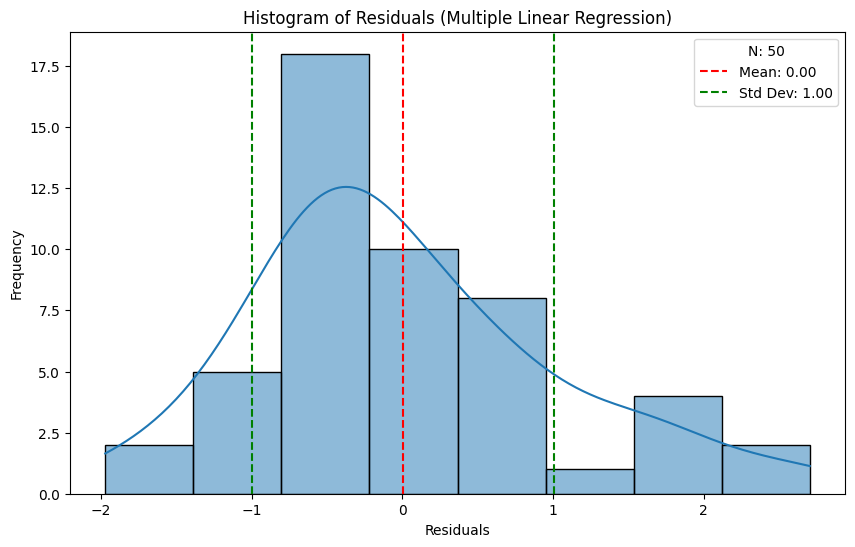

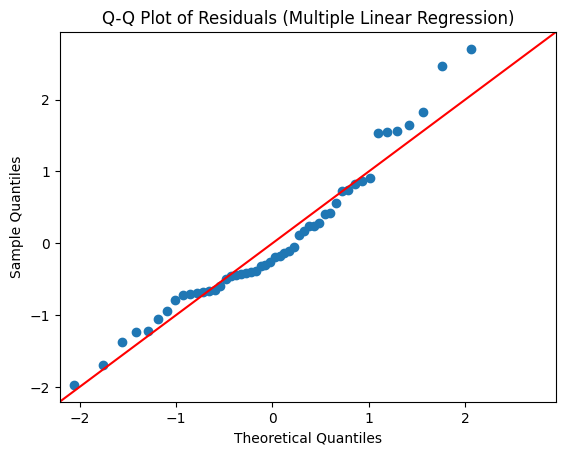


Read file multiple_linear_regression_results_1.xlsx


In [23]:
# Tạo mô hình hồi quy tuyến tính bội sử dụng công thức
# Create the formula for the regression model
formula = f"{dependent_var} ~ {' + '.join(independent_vars)}"
# Create the multiple linear regression model using the formula
model_multiple_optimize = smf.ols(formula, data=table_optimize).fit()
print(model_multiple_optimize.summary())
print()

# Kiểm định Durbin-Watson
residuals_multiple = model_multiple_optimize.resid
durbin_watson_multiple = sm.stats.stattools.durbin_watson(residuals_multiple)

# Redesign the model_summary table
model_summary_multiple = pd.DataFrame({
  'Date': [model_multiple_optimize.summary2().tables[0].iloc[2, 1]],
  'Model': ['OLS'],
  'Dependent Variable': [model_multiple_optimize.summary2().tables[0].iloc[1, 1]],
  'R-squared': [model_multiple_optimize.rsquared],
  'Adj. R-squared': [model_multiple_optimize.rsquared_adj],
  'Durbin Watson': [durbin_watson_multiple]
})
print('Model Summary:')
print(model_summary_multiple)
print()

# Bảng ANOVA
anova_table_multiple = sm.stats.anova_lm(model_multiple_optimize, typ=2, robust='hc3')
# Calculate total sum of squares
total_sum_squares = sum((table[dependent_var] - table[dependent_var].mean())**2)
# Calculate regression sum of squares
regression_sum_squares = total_sum_squares - anova_table_multiple['sum_sq']['Residual']
# Degrees of freedom
df_regression = model_multiple_optimize.summary().tables[0][6][1].data
df_residual = model_multiple_optimize.summary().tables[0][7][1].data
df_total = pd.to_numeric(df_regression, errors='coerce') + pd.to_numeric(df_residual, errors='coerce')
# F-statistic and p-value
f_statistic = pd.to_numeric(model_multiple_optimize.summary().tables[0][2][3].data, errors='coerce')
p_value = pd.to_numeric(model_multiple_optimize.summary().tables[0][3][3].data, errors='coerce')
# Create the ANOVA table
anova_table_multiple = pd.DataFrame({
  'Source': ['Regression', 'Residual', 'Total'],
  'sum_sq': [regression_sum_squares, anova_table_multiple['sum_sq']['Residual'], total_sum_squares],
  'df': [df_regression, df_residual, df_total],
  'F': [f_statistic, None, None],
  'PR(>F)': [p_value, None, None]
})
print('ANOVA Table:')
print(anova_table_multiple)
print()

# Bảng Coefficients
coefficients_multiple = model_multiple_optimize.summary2().tables[1]
# Calculate the standardized coefficients (beta)
standardized_coefficients = model_multiple_optimize.params * (table[independent_vars].std() / table[dependent_var].std())
# Add the standardized coefficients to the coefficients table
coefficients_multiple['Standardized Coef.'] = standardized_coefficients
# Calculate VIF for each independent variable
if len(independent_vars) == 1:
  vif_data == None
else:
  vif_data = pd.DataFrame()
  vif_data["Variable"] = independent_vars
  vif_data["VIF"] = [variance_inflation_factor(table[independent_vars].values, i) for i in range(len(independent_vars))]
# Add the VIP column to the coefficients_multiple dataframe
coefficients_multiple = coefficients_multiple.merge(vif_data, how='left', left_index=True, right_on='Variable')
# Rearrange the columns
if len(independent_vars) == 1:
  coefficients_multiple = coefficients_multiple[['Variable', 'Coef.', 'Std.Err.', 'Standardized Coef.', 't', 'P>|t|', '[0.025', '0.975]']]
else:
  coefficients_multiple = coefficients_multiple[['Variable', 'Coef.', 'Std.Err.', 'Standardized Coef.', 't', 'P>|t|', '[0.025', '0.975]', 'VIF']]
print('Coefficients:')
print(coefficients_multiple)
print()

# Đánh giá Adj. R-squared
adj_r_squared = model_multiple_optimize.rsquared_adj
adj_r_squared_result = 'Model fits well' if adj_r_squared > 0.7 else 'Model fits moderate' if 0.5 < adj_r_squared <= 0.7 else 'Model does not fit'
print('Đánh giá Adj. R-squared:')
print(adj_r_squared_result)
print()

# Kiểm định F - Kiểm tra Sig (p-value) bảng ANOVA
anova_p_value = anova_table_multiple.loc[0, 'PR(>F)']
anova_result = 'Model is significant' if anova_p_value < alpha else 'Model is not significant'
print('Kiểm định F - Kiểm tra Sig (p-value) bảng ANOVA:')
print(anova_result)
print()

# Kiểm định Durbin–Watson
durbin_watson_result = 'No autocorrelation' if 1.5 < durbin_watson_multiple < 2.5 else 'Autocorrelation present'
print('Kiểm định Durbin–Watson:')
print(durbin_watson_result)
print()

# Kiểm định t (student) - Kiểm tra Sig (p-value) từng biến độc lập bảng Coefficients
coefficients_p_values = coefficients_multiple['P>|t|']
# Check the significance of each independent variable excluding 'Intercept'
significant_vars = coefficients_multiple[(coefficients_multiple['P>|t|'] < alpha) & (coefficients_multiple['Variable'] != 'Intercept')]
non_significant_vars = coefficients_multiple[(coefficients_multiple['P>|t|'] >= alpha) & (coefficients_multiple['Variable'] != 'Intercept')]
if significant_vars is None and non_significant_vars is not None:
  result_t_test = f"Non-significant variables: {', '.join(non_significant_vars['Variable'].dropna())}"
elif significant_vars is not None and non_significant_vars is None:
  result_t_test = f"Significant variables: {', '.join(significant_vars['Variable'].dropna())}"
else:
  result_t_test = f"Significant variables: {', '.join(significant_vars['Variable'].dropna())} AND Non-significant variables: {', '.join(non_significant_vars['Variable'].dropna())}"
# Check for multicollinearity using VIF
if len(independent_vars) == 1:
  multicollinearity_result = "The model is suitable as all variables meet the VIF criteria"
else:
  multicollinearity_vars = vif_data[vif_data['VIF'] > 10]
  if not multicollinearity_vars.empty:
    multicollinearity_result = "There is a possibility of multicollinearity"
  else:
    multicollinearity_result = "The model is suitable as all variables meet the VIF criteria"
print('Kiểm định t (student)')
print(multicollinearity_result)
print()

# Predict the values using the regression model
predicted_values = model_multiple_optimize.predict(table_optimize) # Prediction using model_multiple
# Add the predicted values to the dataframe
table['predicted_values'] = predicted_values # Adding the column to 'table'
# Calculate MSE using NumPy
mse = np.mean((table[dependent_var] - table['predicted_values'])**2)
# Calculate RMSE
rmse = np.sqrt(mse)
# Evaluate MSE and RMSE
if mse < 10 : # example threshold, adjust as needed
  mse = "The model's Mean Squared Error (MSE) is relatively low, suggesting good fit."
else:
  mse = "The model's Mean Squared Error (MSE) is high, indicating poor fit. Consider model improvement."
if rmse < 3: # example threshold, adjust as needed
  rmse = "The model's Root Mean Squared Error is relatively low, suggesting accurate predictions."
else:
  rmse = "The model's Root Mean Squared Error is high, suggesting inaccurate predictions. Consider model improvement."
print('Đánh giá MSE và RMSE:')
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print()

# Kiểm tra nếu có điểm nào không đạt yêu cầu
if adj_r_squared_result != 'Model fits well' or anova_result != 'Model is significant' or durbin_watson_result != 'No autocorrelation' or multicollinearity_result != 'The model is suitable as all variables meet the VIF criteria' or {', '.join(non_significant_vars['Variable'].dropna())} == '' in result_t_test:
  conclusion = "Should Optimized Model"
else:
  conclusion = "Model Meets Requirements"
print('Đánh giá tổng hợp:')
print(multicollinearity_result)
print()

# Tạo bảng hypothesis_test
hypothesis_test = pd.DataFrame({
  'Đánh giá Adj. R-squared': [f'Adjusted R-squared: {adj_r_squared:.3f}, Result: {adj_r_squared_result}'],
  'Kiểm định F': [f'ANOVA p-value: {anova_p_value:.3e}, Result: {anova_result}'],
  'Kiểm định t (student)': [result_t_test],
  'Kiểm định Durbin-Watson': [f'Durbin-Watson: {durbin_watson_multiple:.3f}, Result: {durbin_watson_result}'],
  'Kiểm định VIP': [multicollinearity_result],
  'mse': [mse],
  'rmse': [rmse],
  'Conclusion': [conclusion]
})
hypothesis_test = hypothesis_test.melt(var_name='Test', value_name='Result')
print('Hypothsis Test:')
print(hypothesis_test)
print()

# Viết phương trình hồi quy
intercept = coefficients_multiple.loc[coefficients_multiple['Variable'] == 'Intercept', 'Coef.'].values[0]
slopes = coefficients_multiple.loc[coefficients_multiple['Variable'] != 'Intercept', ['Variable', 'Coef.']]
regression_equation = f'y = {intercept:.2f}'
for index, row in slopes.iterrows():
  regression_equation += f' + {row["Coef."]:.2f} * {row["Variable"]}'
  regression_equation = f'y = {intercept:.2f}'
  for index, row in slopes.iterrows():
    coef = row["Coef."]
    variable = row["Variable"]
    sign = '+' if coef >= 0 else '-'
    regression_equation += f' {sign} {abs(coef):.2f} * {variable}'
print('Regression Equation:')
print(regression_equation)
print()

# Tạo bảng phương trình hồi quy
regression_equation_df = pd.DataFrame({
  'Function': [regression_equation],
  'Conclusion': [conclusion]
})

# Biểu đồ Histogram để khảo sát phân phối của phần dư
standardized_residuals_multiple = model_multiple_optimize.get_influence().resid_studentized_internal
mean_residuals_multiple = standardized_residuals_multiple.mean()
std_dev_residuals_multiple = standardized_residuals_multiple.std()
N_residuals_multiple = len(standardized_residuals_multiple)
plt.figure(figsize=(10, 6))
sns.histplot(standardized_residuals_multiple, kde=True)
plt.title('Histogram of Residuals (Multiple Linear Regression)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.axvline(mean_residuals_multiple, color='r', linestyle='--', label=f'Mean: {mean_residuals_multiple:.2f}')
plt.axvline(mean_residuals_multiple + std_dev_residuals_multiple, color='g', linestyle='--', label=f'Std Dev: {std_dev_residuals_multiple:.2f}')
plt.axvline(mean_residuals_multiple - std_dev_residuals_multiple, color='g', linestyle='--')
plt.legend(title=f'N: {N_residuals_multiple}')
plt.savefig('histogram_of_residuals_multiple_1.png')
plt.show()
print()

# Biểu đồ Q-Q plot để khảo sát phân phối của phần dư
sm.qqplot(standardized_residuals_multiple, line='45')
plt.title('Q-Q Plot of Residuals (Multiple Linear Regression)')
plt.savefig('qq_plot_of_residuals_multiple_1.png')
plt.show()
print()

# Lưu kết quả vào file Excel
with pd.ExcelWriter('multiple_linear_regression_results_1.xlsx') as writer:
  correlation_matrix.to_excel(writer, sheet_name='Corr Matrix')
  model_summary_multiple.to_excel(writer, sheet_name='Model Summary')
  anova_table_multiple.to_excel(writer, sheet_name='ANOVA')
  coefficients_multiple.to_excel(writer, sheet_name='Coefficients')
  hypothesis_test.to_excel(writer, sheet_name='Hypothesis Test', index=False)
  regression_equation_df.to_excel(writer, sheet_name='Regression Equation', index=False)
  # Access the XlsxWriter workbook and worksheet objects
  workbook  = writer.book
  worksheet = workbook.add_worksheet('Residuals Plots')

  # Insert the images into the worksheet
  worksheet.insert_image('A1', 'histogram_of_residuals_multiple_1.png')
  worksheet.insert_image('A10', 'qq_plot_of_residuals_multiple_1.png')

print('Read file multiple_linear_regression_results_1.xlsx')

## 4.2.8 Predict the values using the regression model

In [24]:
# Predict the values using the regression model
predicted_values = model_multiple_optimize.predict(table_optimize)

# Add the predicted values to the dataframe
table_optimize['predicted_values'] = predicted_values

# Display the dataframe with the predicted values
print(table_optimize[['nang', 'ttxang', 'predicted_values']])

    nang  ttxang  predicted_values
0    893  18.964         16.176661
1   1514   8.756          9.464717
2   1591   8.448          8.632479
3   1550   7.788          9.075619
4   1442   7.964         10.242914
5   1274   8.932         12.058705
6   1460   9.460         10.048364
7   1962   7.436          4.622607
8   1824   6.820          6.114150
9   1773   8.140          6.665372
10  1436  11.968         10.307763
11   965  18.260         15.398464
12   950  20.504         15.560589
13  1089  10.428         14.058237
14  1121  11.968         13.712372
15   790  17.204         17.289914
16  1172  12.320         13.161150
17  1289  10.560         11.896581
18  1607   8.888          8.459547
19  1420   9.020         10.480696
20  1205  12.320         12.804477
21   997  15.268         15.052599
22   810  15.884         17.073748
23   862  15.708         16.511717
24  1334   8.888         11.410208
25  1539  10.516          9.194510
26  1071  13.156         14.252786
27  1463  13.376    

<ipython-input-24-a063a7d68a6b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_optimize['predicted_values'] = predicted_values


**Define the value of x for which you want to predict y**

In [25]:
# Example prediction for new data
# Define the value of independent variables for which you want to predict the dependent variable
new_data = pd.DataFrame({'nang': [1200]})

# Predict the dependent variable value using the regression model
predicted_values = model_multiple_optimize.predict(new_data)

# Display the predicted value
print(f'Predicted ttxang for nang=1200: {predicted_values.iloc[0]}')

Predicted ttxang for nang=1200: 12.858517926221708


#4.3 Non-linear Regression

## 4.3.1 Input Data
* Independent variable: Lifeexpf - Tuổi thọ người phụ nữ
* Dependent variable:
  - Urban - Tỷ lệ dân sống ở đô thị
  - Density - Mật độ dân số
  - Literacy - Tỷ lệ dân biết chữ
  - Gdp_cap - GDP bình quân đầu người
  - Calories - Lượng calori một người tiêu thụ mỗi ngày
  - Fertilty - Số con trung bình của một phụ nữ
  - Lit_fema - Tỷ lệ phụ nữ biết chữ

In [26]:
# File path to your .sav file
file_path = "/content/drive/My Drive/Colab Notebooks/Data/World 95 - Viet.csv"

# Read the SPSS file
raw_data = pd.read_csv(file_path)
world95 = raw_data[['lifeexpf','urban','density','literacy','gdp_cap','calories','fertilty','lit_fema']]
world95 = world95[~world95.isin([' ']).any(axis=1)]

print(world95.head())

    lifeexpf urban  density literacy  gdp_cap calories fertilty lit_fema
1         75    86     12.0       95     3408     3113      2.8       95
3         80    85      2.3      100    16848     3216      1.9      100
7         53    16    800.0       35      202     2021      4.7       22
11        64    51      6.9       78      730     1916     4.21       71
13        66    25      2.4       72     2677     2375      5.1       16


## 4.3.2 Input Test Value

In [27]:
# Input Data
table = world95
# Input the dependent variable
dependent_var = 'lifeexpf'

# Define the independent variables
independent_vars = table.columns.drop(dependent_var).tolist()
# Define the confidence interval
confidence_interval = 0.95
z_value = norm.ppf((1 + confidence_interval) / 2)
alpha = round(1 - confidence_interval, 3)

## 4.3.3 Correlation Coefficient

Read file nonlinear_regression_correlation_coefficient_results.xlsx


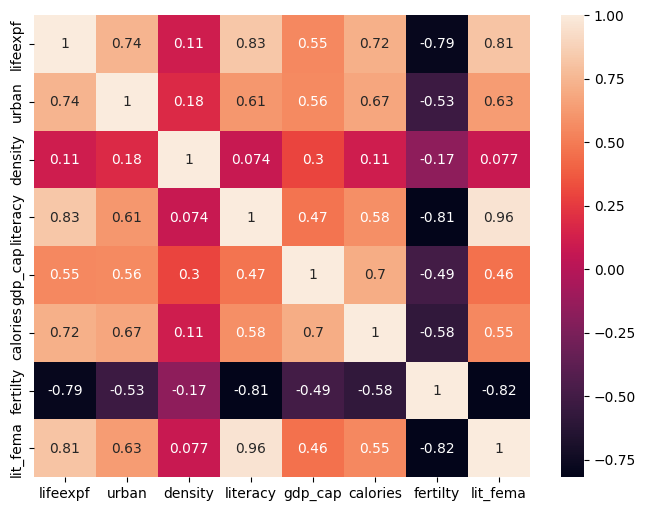

In [28]:
# Calculate the correlation matrix
correlation_matrix = table.corr()

# Save the correlation matrix to an Excel file
correlation_matrix.to_excel('nonlinear_regression_correlation_coefficient_results.xlsx')

#Correlation Heatmap (print the correlation score each variables)
plt.figure(figsize=(8, 6))
sns.heatmap(table.corr(), fmt='.2g', annot=True)

print('Read file nonlinear_regression_correlation_coefficient_results.xlsx')

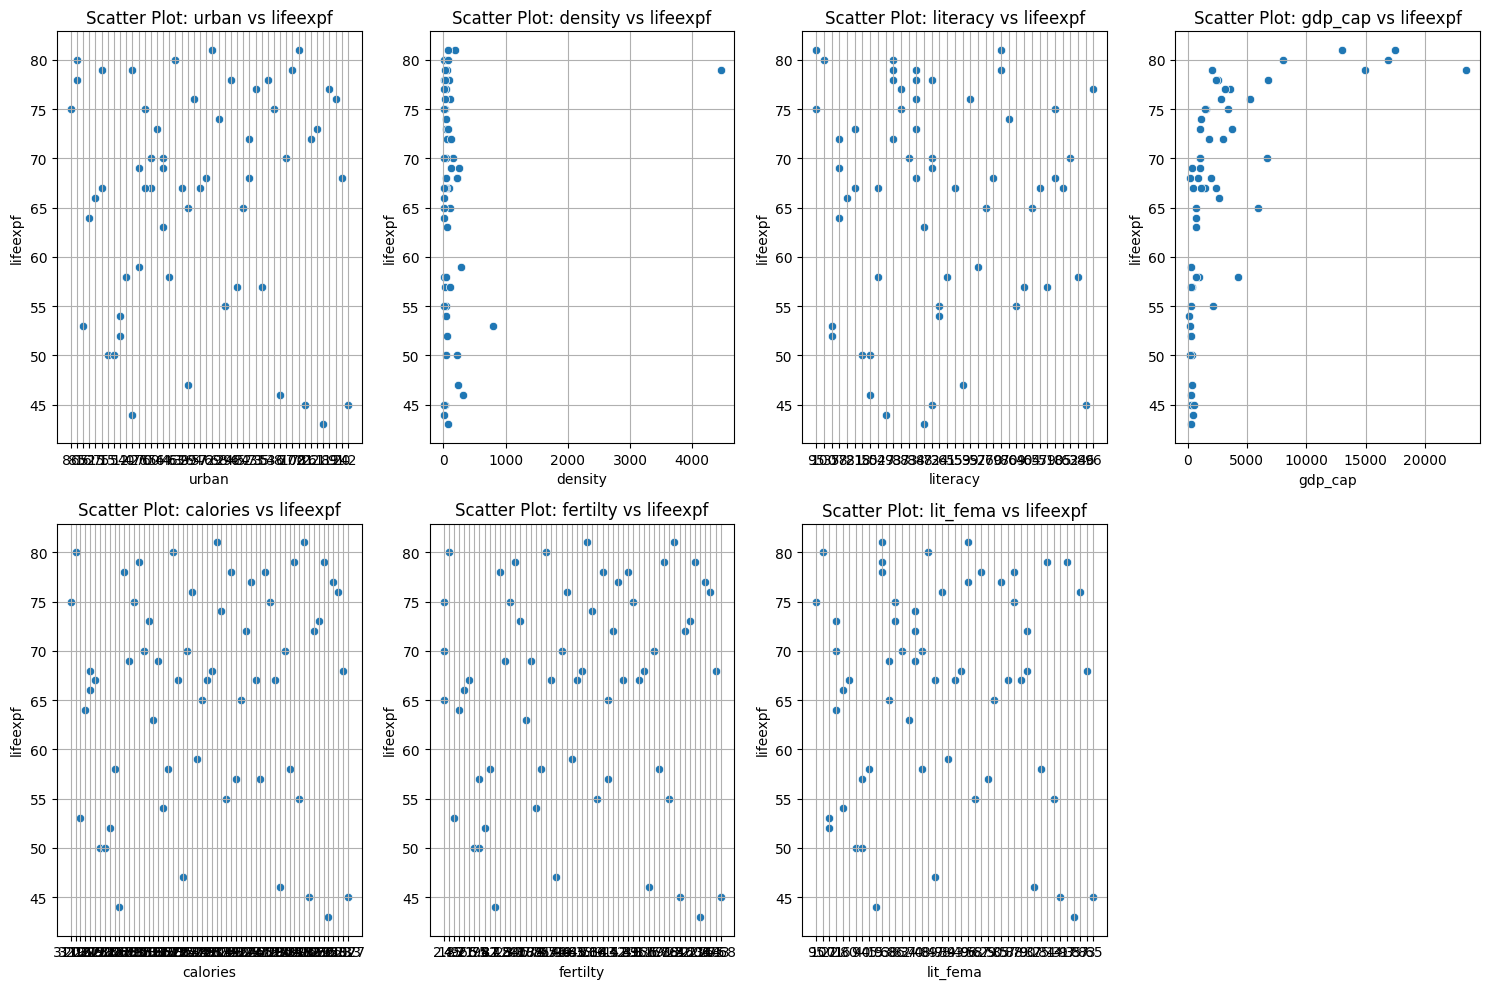

In [29]:
# Biểu đồ phân tán cho từng biến độc lập
num_plots = len(independent_vars)
cols = 4  # Number of columns in the subplot grid
rows = (num_plots + cols - 1) // cols  # Calculate the number of rows needed

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))  # Adjust figsize as needed
axes = axes.ravel()  # Flatten the axes array for easier iteration


for i, col in enumerate(independent_vars):
    sns.scatterplot(x=col, y=dependent_var, data=table, ax=axes[i])
    axes[i].set_title(f'Scatter Plot: {col} vs {dependent_var}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel(f'{dependent_var}')
    axes[i].grid(True)

# Hide any unused subplots
for j in range(i + 1, rows * cols):
    fig.delaxes(axes[j])

plt.tight_layout()  # Adjust layout to prevent overlapping titles/labels
plt.show()

```
Literacy và Lit_fema cùng giải thích về việc biết chữ, Literacy tương quan với biến phụ thuộc Lifeexpf. --> Nên loại biến Lit_fema.
```

In [30]:
# Remove Lit_fema
# independent_vars.remove('lit_fema')
independent_vars

# Create a new table with dependent and independent variables
new_table = table[[dependent_var] + independent_vars]

# Change string to float
new_table['lifeexpf'] = table['lifeexpf'].astype('float64')
new_table['urban'] = table['urban'].astype('float64')
new_table['density'] = table['density'].astype('float64')
new_table['literacy'] = table['literacy'].astype('float64')
new_table['gdp_cap'] = table['gdp_cap'].astype('float64')
new_table['calories'] = table['calories'].astype('float64')
new_table['fertilty'] = table['fertilty'].astype('float64')
new_table['lit_fema'] = table['lit_fema'].astype('float64')
# Display the new table
new_table.head()

,lifeexpf,urban,density,literacy,gdp_cap,calories,fertilty,lit_fema
1,75.0,86.0,12.0,95.0,3408.0,3113.0,2.80,95.0
3,80.0,85.0,2.3,100.0,16848.0,3216.0,1.90,100.0
7,53.0,16.0,800.0,35.0,202.0,2021.0,4.70,22.0
11,64.0,51.0,6.9,78.0,730.0,1916.0,4.21,71.0
13,66.0,25.0,2.4,72.0,2677.0,2375.0,5.10,16.0


## 4.3.4 Curve Estimation
Check of possible regression forms between independent variable and each dependent variable

In [31]:
# Create an empty list to store the results
results = []

# Loop through each independent variable
for independent_var in independent_vars:
    # Fit different regression models
    models = {
        "Linear": f"{dependent_var} ~ {independent_var}",
        "Logarithmic": f"{dependent_var} ~ np.log({independent_var})",
        "Quadratic": f"{dependent_var} ~ {independent_var} + I({independent_var}**2)",
        "Cubic": f"{dependent_var} ~ {independent_var} + I({independent_var}**2) + I({independent_var}**3)",
        "Power": f"np.log({dependent_var}) ~ np.log({independent_var})",  # Log-log transformation
        "Exponential": f"np.log({dependent_var}) ~ {independent_var}"  # Log transformation
    }

    for model_name, formula in models.items():
        try:
            # Fit the model
            model = smf.ols(formula, data=new_table).fit()

            # Extract relevant information
            rsquared = model.rsquared
            df = int(model.df_resid)  # Convert to integer
            f_statistic = model.fvalue
            p_value = model.f_pvalue
            aic = model.aic
            bic = model.bic

            # Append the results to the list
            results.append([dependent_var, independent_var, model_name, rsquared, df, f_statistic, p_value, aic, bic])

        except (ValueError, TypeError, np.linalg.LinAlgError) as e:  # Handle potential errors
            print(f"Error fitting model {model_name} for {dependent_var} ~ {independent_var}: {e}")
            # Append NaN values for the failed models
            results.append([dependent_var, independent_var, model_name, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan])

# Create a Pandas DataFrame from the results
results_df = pd.DataFrame(results, columns=['Dependent Var', 'Independent Vars', 'Model Name', 'rsquared', 'df', 'F Statistic', 'p_value', 'AIC', 'BIC']) # Added 'Model_Name' column
print('Curve Estimation:')
print(results_df)
print()

# Filter for significant p-values
significant_models = results_df[results_df['p_value'] <= 0.05]
# Group by 'Independent Vars' and select the row with the highest R-squared value within each group
best_models = significant_models.loc[significant_models.groupby('Independent Vars')['rsquared'].idxmax()]
print('Best Model in each Dependent Variables:')
print(best_models)

Curve Estimation:
   Dependent Var Independent Vars   Model Name  rsquared  df  F Statistic       p_value         AIC         BIC
0       lifeexpf            urban       Linear  0.548966  57    69.376406  1.956230e-11  407.238510  411.393585
1       lifeexpf            urban  Logarithmic  0.537430  57    66.224584  4.058526e-11  408.728627  412.883702
2       lifeexpf            urban    Quadratic  0.562967  56    36.068319  8.598282e-11  407.378125  413.610737
3       lifeexpf            urban        Cubic  0.563012  55    23.620540  5.914787e-10  409.371966  417.682116
4       lifeexpf            urban        Power  0.531650  57    64.703857  5.811364e-11  -76.493046  -72.337972
5       lifeexpf            urban  Exponential  0.526541  57    63.390458  7.953338e-11  -75.852872  -71.697797
6       lifeexpf          density       Linear  0.012445  57     0.718277  4.002542e-01  453.476274  457.631348
7       lifeexpf          density  Logarithmic  0.000016  57     0.000900  9.761665e-0

In [32]:
# Create a new table to store the transformed variables
X = pd.DataFrame()

# Iterate over the best models
for index, row in best_models.iterrows():
    dependent_var = row['Dependent Var']
    independent_var = row['Independent Vars']
    model_name = row['Model Name']

    # Apply the transformation based on the best model name
    if model_name == 'Linear':
        x[f'{independent_var}'] = new_table[independent_var]
    elif model_name == 'Logarithmic':
        X[f'{independent_var}_log'] = np.log(new_table[independent_var])
    elif model_name == 'Quadratic':
        x[f'{independent_var}_qua'] = new_table[independent_var] ** 2
    elif model_name == 'Cubic':
        X[f'{independent_var}_cub'] = new_table[independent_var] ** 3
    elif model_name == 'Power':
        X[f'{independent_var}_pow'] = np.log(new_table[independent_var]) # Assuming this is what you intended
    elif model_name == 'Exponential':
        X[f'{independent_var}_exp'] = np.exp(new_table[independent_var]) # Assuming this is what you intended
    else:
        print(f"Warning: Unknown model name '{model_name}' for {independent_var}")
        X[f'{independent_var}_cu'] = new_table[independent_var] # Default to original value if unknown model

y = table[dependent_var]

# Concatenate X and y into a single DataFrame
combined_df = pd.concat([X, y], axis=1)

# Display the combined DataFrame
print(combined_df.head())

    calories_cub  fertilty_cub  gdp_cap_log  lit_fema_cub  literacy_cub  urban_cub  lifeexpf
1   3.016736e+10     21.952000     8.133881      857375.0      857375.0   636056.0        75
3   3.326198e+10      6.859000     9.731987     1000000.0     1000000.0   614125.0        80
7   8.254655e+09    103.823000     5.308268       10648.0       42875.0     4096.0        53
11  7.033743e+09     74.618461     6.593045      357911.0      474552.0   132651.0        64
13  1.339648e+10    132.651000     7.892452        4096.0      373248.0    15625.0        66


## 4.3.5 Stepwise Selection
Sử dụng phương pháp chọn từng bước. Đưa vào dần và loại trừ dần để tìm model phù hợp.

In [33]:
# Function to calculate VIF
def calculate_vif(X):
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    if X.shape[1] > 1:  # Check if there are more than 1 columns
        vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    else:
        vif["VIF"] = [np.nan]  # Assign NaN if only one column is present
    return vif

# Function to perform stepwise regression
def stepwise_selection(X, y, threshold_in=0.05, threshold_out=0.05):
    initial_features = X.columns.tolist()
    best_features = []
    model_details = []  # List to store details of each regression model

    while True:
        changed = False

        # Forward step
        remaining_features = list(set(initial_features) - set(best_features))
        new_pval = pd.Series(index=remaining_features)
        for new_column in remaining_features:
            model = sm.OLS(y, sm.add_constant(X[best_features + [new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]

            # Save model details
            model_details.append({
                'Features': best_features + [new_column],
                'AIC': model.aic,
                'BIC': model.bic,
                'R-squared': model.rsquared,
                'Adjusted R-squared': model.rsquared_adj
            })

        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_features.append(new_pval.idxmin())
            changed = True

        # Backward step
        model = sm.OLS(y, sm.add_constant(X[best_features])).fit()
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max()
        if worst_pval > threshold_out:
            changed = True
            worst_feature = pvalues.idxmax()
            best_features.remove(worst_feature)

        if not changed:
            break

    return best_features, model_details

# Perform stepwise regression
best_features, model_details = stepwise_selection(X, y)

# Print details of all regression models
print("All Models Details:")
for idx, details in enumerate(model_details, 1):
    print(f"Model {idx}:")
    print(f"Features: {details['Features']}")
    print(f"R-squared: {details['R-squared']:.4f}, Adjusted R-squared: {details['Adjusted R-squared']:.4f}") #AIC: {details['AIC']:.4f}, BIC: {details['BIC']:.4f},

    # Calculate VIF for the current model
    current_model_X = X[details['Features']]
    current_vif = calculate_vif(current_model_X)
    print(f"VIF for Model {idx}:")
    print(current_vif)
    print("-" * 40)
print()

# Filter for significant p-values and VIF < 10
filtered_models = []
for idx, details in enumerate(model_details):
    current_model_X = X[details["Features"]]
    current_vif = calculate_vif(current_model_X)

    # Check for VIF values less than 10 (excluding intercept if present)
    valid_vif = True
    if 'const' in current_vif['Variable'].values:
      current_vif = current_vif[current_vif['Variable'] != 'const']

    #Check if all VIF values are less than 10
    if len(current_vif) > 0 and current_vif['VIF'].max() >= 10:
        valid_vif = False

    if valid_vif:
        filtered_models.append(details)

# Find best model within filtered ones
best_model_filtered = None
best_r_squared = -1

for model in filtered_models:
    if model['R-squared'] > best_r_squared:
        best_r_squared = model['R-squared']
        best_model_filtered = model

print("Best Model after filtering by VIF < 10:")
if best_model_filtered:
    # print(best_model_filtered)
    #Fit the best model
    best_model = sm.OLS(y, sm.add_constant(X[best_model_filtered['Features']])).fit()
    print(best_model.summary())
    print()
    print("VIF for best model:")
    print(calculate_vif(X[best_model_filtered['Features']]))
else:
    print("No model found within VIF < 10")

All Models Details:
Model 1:
Features: ['fertilty_cub']
R-squared: 0.5570, Adjusted R-squared: 0.5493
VIF for Model 1:
       Variable  VIF
0  fertilty_cub  NaN
----------------------------------------
Model 2:
Features: ['calories_cub']
R-squared: 0.4296, Adjusted R-squared: 0.4196
VIF for Model 2:
       Variable  VIF
0  calories_cub  NaN
----------------------------------------
Model 3:
Features: ['urban_cub']
R-squared: 0.3984, Adjusted R-squared: 0.3878
VIF for Model 3:
    Variable  VIF
0  urban_cub  NaN
----------------------------------------
Model 4:
Features: ['literacy_cub']
R-squared: 0.6870, Adjusted R-squared: 0.6815
VIF for Model 4:
       Variable  VIF
0  literacy_cub  NaN
----------------------------------------
Model 5:
Features: ['lit_fema_cub']
R-squared: 0.6448, Adjusted R-squared: 0.6386
VIF for Model 5:
       Variable  VIF
0  lit_fema_cub  NaN
----------------------------------------
Model 6:
Features: ['gdp_cap_log']
R-squared: 0.5860, Adjusted R-squared: 0.578

## 4.3.6 Non-linear Regression

In [34]:
independent_vars = best_model_filtered['Features']
dependent_var = y.name
print(dependent_var)
table_nonlinear = combined_df[[dependent_var] + independent_vars] # Use combined_df
print(table_nonlinear.head())

lifeexpf
    lifeexpf  literacy_cub  gdp_cap_log  urban_cub
1         75      857375.0     8.133881   636056.0
3         80     1000000.0     9.731987   614125.0
7         53       42875.0     5.308268     4096.0
11        64      474552.0     6.593045   132651.0
13        66      373248.0     7.892452    15625.0


**Correlation Coefficient**

Read file nonlinear_regression_correlation_coefficient_results_1.xlsx



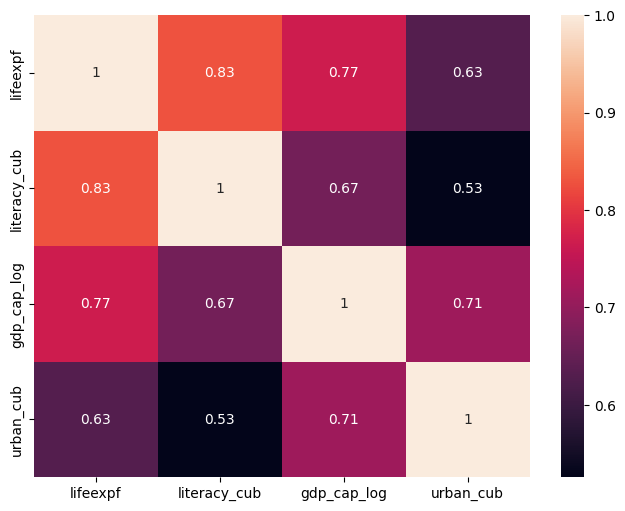

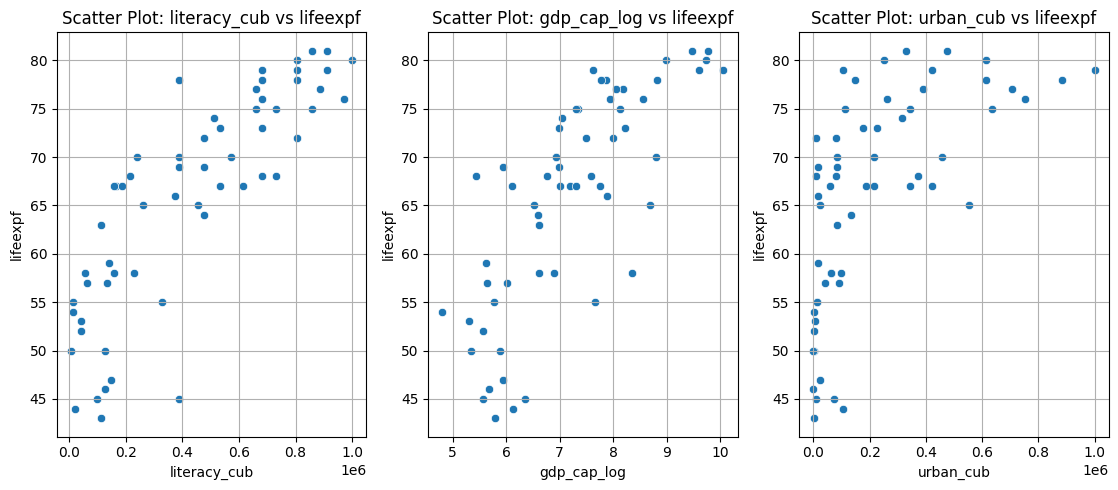

In [35]:
# Calculate the correlation matrix
correlation_matrix = table_nonlinear.corr()

# Save the correlation matrix to an Excel file
correlation_matrix.to_excel('nonlinear_regression_correlation_coefficient_results_1.xlsx')

#Correlation Heatmap (print the correlation score each variables)
plt.figure(figsize=(8, 6))
sns.heatmap(table_nonlinear.corr(), fmt='.2g', annot=True)
print('Read file nonlinear_regression_correlation_coefficient_results_1.xlsx')
print()

# Biểu đồ phân tán cho từng biến độc lập
num_plots = len(independent_vars)
cols = 4  # Number of columns in the subplot grid
rows = (num_plots + cols - 1) // cols  # Calculate the number of rows needed

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))  # Adjust figsize as needed
axes = axes.ravel()  # Flatten the axes array for easier iteration

for i, col in enumerate(independent_vars):
    sns.scatterplot(x=col, y=dependent_var, data=table_nonlinear, ax=axes[i])
    axes[i].set_title(f'Scatter Plot: {col} vs {dependent_var}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel(f'{dependent_var}')
    axes[i].grid(True)

# Hide any unused subplots
for j in range(i + 1, rows * cols):
    fig.delaxes(axes[j])

plt.tight_layout()  # Adjust layout to prevent overlapping titles/labels
plt.show()

**Non-linear Regression**

                            OLS Regression Results                            
Dep. Variable:               lifeexpf   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                     63.30
Date:                Sat, 11 Jan 2025   Prob (F-statistic):           7.72e-18
Time:                        06:21:49   Log-Likelihood:                -181.05
No. Observations:                  59   AIC:                             370.1
Df Residuals:                      55   BIC:                             378.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       36.8156      5.403      6.814   

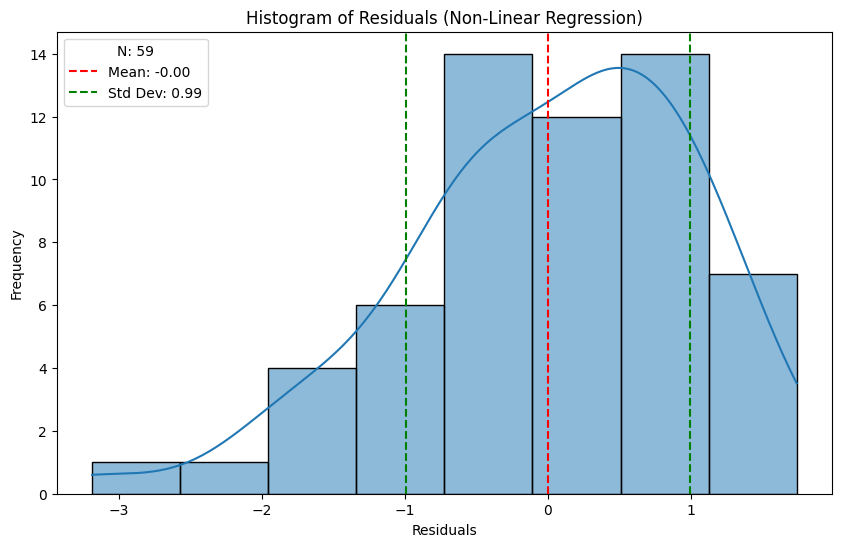

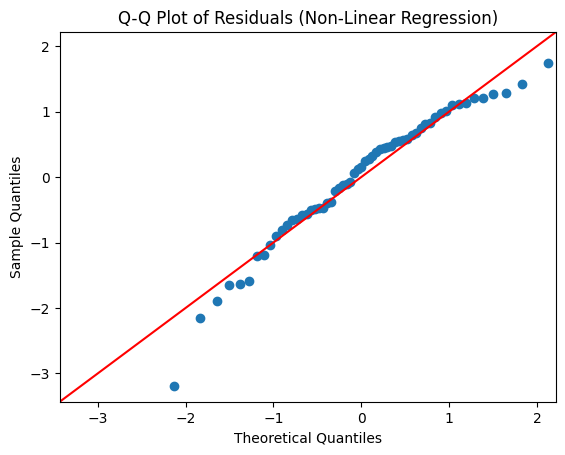


Read file non_linear_regression_results.xlsx


In [36]:
# Tạo mô hình hồi quy phi tuyến tính sử dụng công thức
# Create the formula for the none-linear regression model
formula = f"{dependent_var} ~ {' + '.join(independent_vars)}"
# Create the non-linear regression model using the formula
model_nonlinear_optimize = smf.ols(formula, data=table_nonlinear).fit()
print(model_nonlinear_optimize.summary())
print()

# Kiểm định Durbin-Watson
residuals_nonelinear = model_nonlinear_optimize.resid
durbin_watson_nonlinear = sm.stats.stattools.durbin_watson(residuals_nonelinear)

# Redesign the model_summary table
model_summary_nonlinear = pd.DataFrame({
  'Date': [model_nonlinear_optimize.summary2().tables[0].iloc[2, 1]],
  'Model': ['OLS'],
  'Dependent Variable': [model_nonlinear_optimize.summary2().tables[0].iloc[1, 1]],
  'R-squared': [model_nonlinear_optimize.rsquared],
  'Adj. R-squared': [model_nonlinear_optimize.rsquared_adj],
  'Durbin Watson': [durbin_watson_nonlinear]
})
print('Model Summary:')
print(model_summary_nonlinear)
print()

# Bảng ANOVA
anova_table_nonlinear = sm.stats.anova_lm(model_nonlinear_optimize, typ=2, robust='hc3')
# Calculate total sum of squares
total_sum_squares = sum((table_nonlinear[dependent_var] - table_nonlinear[dependent_var].mean())**2)
# Calculate regression sum of squares
regression_sum_squares = total_sum_squares - anova_table_nonlinear['sum_sq']['Residual']
# Degrees of freedom
df_regression = model_nonlinear_optimize.summary().tables[0][6][1].data
df_residual = model_nonlinear_optimize.summary().tables[0][7][1].data
df_total = pd.to_numeric(df_regression, errors='coerce') + pd.to_numeric(df_residual, errors='coerce')
# F-statistic and p-value
f_statistic = pd.to_numeric(model_nonlinear_optimize.summary().tables[0][2][3].data, errors='coerce')
p_value = pd.to_numeric(model_nonlinear_optimize.summary().tables[0][3][3].data, errors='coerce')
# Create the ANOVA table
anova_table_nonlinear = pd.DataFrame({
  'Source': ['Regression', 'Residual', 'Total'],
  'sum_sq': [regression_sum_squares, anova_table_nonlinear['sum_sq']['Residual'], total_sum_squares],
  'df': [df_regression, df_residual, df_total],
  'F': [f_statistic, None, None],
  'PR(>F)': [p_value, None, None]
})
print('ANOVA Table:')
print(anova_table_nonlinear)
print()

# Bảng Coefficients
coefficients_nonlinear = model_nonlinear_optimize.summary2().tables[1]
# Calculate the standardized coefficients (beta)
standardized_coefficients = model_nonlinear_optimize.params * (table_nonlinear[independent_vars].std() / table_nonlinear[dependent_var].std())
# Add the standardized coefficients to the coefficients table
coefficients_nonlinear['Standardized Coef.'] = standardized_coefficients
# Calculate VIF for each independent variable
if len(independent_vars) == 1:
  vif_data == None
else:
  vif_data = pd.DataFrame()
  vif_data["Variable"] = independent_vars
  vif_data["VIF"] = [variance_inflation_factor(table_nonlinear[independent_vars].values, i) for i in range(len(independent_vars))]
# Add the VIP column to the coefficients_nonlinear dataframe
coefficients_nonlinear = coefficients_nonlinear.merge(vif_data, how='left', left_index=True, right_on='Variable')
# Rearrange the columns
if len(independent_vars) == 1:
  coefficients_nonlinear = coefficients_nonlinear[['Variable', 'Coef.', 'Std.Err.', 'Standardized Coef.', 't', 'P>|t|', '[0.025', '0.975]']]
else:
  coefficients_nonlinear = coefficients_nonlinear[['Variable', 'Coef.', 'Std.Err.', 'Standardized Coef.', 't', 'P>|t|', '[0.025', '0.975]', 'VIF']]
print('Coefficients:')
print(coefficients_nonlinear)
print()

# Đánh giá Adj. R-squared
adj_r_squared = model_nonlinear_optimize.rsquared_adj
adj_r_squared_result = 'Model fits well' if adj_r_squared > 0.7 else 'Model fits moderate' if 0.5 < adj_r_squared <= 0.7 else 'Model does not fit'
print('Đánh giá Adj. R-squared:')
print(adj_r_squared_result)
print()

# Kiểm định F - Kiểm tra Sig (p-value) bảng ANOVA
anova_p_value = anova_table_nonlinear.loc[0, 'PR(>F)']
anova_result = 'Model is significant' if anova_p_value < alpha else 'Model is not significant'
print('Kiểm định F - Kiểm tra Sig (p-value) bảng ANOVA:')
print(anova_result)
print()

# Kiểm định Durbin–Watson
durbin_watson_result = 'No autocorrelation' if 1.5 < durbin_watson_nonlinear < 2.5 else 'Autocorrelation present'
print('Kiểm định Durbin–Watson:')
print(durbin_watson_result)
print()

# Kiểm định t (student) - Kiểm tra Sig (p-value) từng biến độc lập bảng Coefficients
coefficients_p_values = coefficients_nonlinear['P>|t|']
# Check the significance of each independent variable excluding 'Intercept'
significant_vars = coefficients_nonlinear[(coefficients_nonlinear['P>|t|'] < alpha) & (coefficients_nonlinear['Variable'] != 'Intercept')]
non_significant_vars = coefficients_nonlinear[(coefficients_nonlinear['P>|t|'] >= alpha) & (coefficients_nonlinear['Variable'] != 'Intercept')]
if significant_vars is None and non_significant_vars is not None:
  result_t_test = f"Non-significant variables: {', '.join(non_significant_vars['Variable'].dropna())}"
elif significant_vars is not None and non_significant_vars is None:
  result_t_test = f"Significant variables: {', '.join(significant_vars['Variable'].dropna())}"
else:
  result_t_test = f"Significant variables: {', '.join(significant_vars['Variable'].dropna())} AND Non-significant variables: {', '.join(non_significant_vars['Variable'].dropna())}"
# Check for multicollinearity using VIF
if len(independent_vars) == 1:
  multicollinearity_result = "The model is suitable as all variables meet the VIF criteria"
else:
  multicollinearity_vars = vif_data[vif_data['VIF'] > 10]
  if not multicollinearity_vars.empty:
    multicollinearity_result = "There is a possibility of multicollinearity"
  else:
    multicollinearity_result = "The model is suitable as all variables meet the VIF criteria"
print('Kiểm định t (student)')
print(multicollinearity_result)
print()

# Predict the values using the regression model
predicted_values = model_nonlinear_optimize.predict(table_nonlinear) # Prediction using model_nonlinear
# Add the predicted values to the dataframe
table['predicted_values'] = predicted_values # Adding the column to 'table'
# Calculate MSE using NumPy
mse = np.mean((table[dependent_var] - table['predicted_values'])**2)
# Calculate RMSE
rmse = np.sqrt(mse)
# Evaluate MSE and RMSE
if mse < 10 : # example threshold, adjust as needed
  mse = "The model's Mean Squared Error (MSE) is relatively low, suggesting good fit."
else:
  mse = "The model's Mean Squared Error (MSE) is high, indicating poor fit. Consider model improvement."
if rmse < 3: # example threshold, adjust as needed
  rmse = "The model's Root Mean Squared Error is relatively low, suggesting accurate predictions."
else:
  rmse = "The model's Root Mean Squared Error is high, suggesting inaccurate predictions. Consider model improvement."
print('Đánh giá MSE và RMSE:')
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print()

# Kiểm tra nếu có điểm nào không đạt yêu cầu
if adj_r_squared_result != 'Model fits well' or anova_result != 'Model is significant' or durbin_watson_result != 'No autocorrelation' or multicollinearity_result != 'The model is suitable as all variables meet the VIF criteria' or {', '.join(non_significant_vars['Variable'].dropna())} == '' in result_t_test:
  conclusion = "Should Optimized Model"
else:
  conclusion = "Model Meets Requirements"
print('Đánh giá tổng hợp:')
print(multicollinearity_result)
print()

# Tạo bảng hypothesis_test
hypothesis_test = pd.DataFrame({
  'Đánh giá Adj. R-squared': [f'Adjusted R-squared: {adj_r_squared:.3f}, Result: {adj_r_squared_result}'],
  'Kiểm định F': [f'ANOVA p-value: {anova_p_value:.3e}, Result: {anova_result}'],
  'Kiểm định t (student)': [result_t_test],
  'Kiểm định Durbin-Watson': [f'Durbin-Watson: {durbin_watson_nonlinear:.3f}, Result: {durbin_watson_result}'],
  'Kiểm định VIP': [multicollinearity_result],
  'mse': [mse],
  'rmse': [rmse],
  'Conclusion': [conclusion]
})
hypothesis_test = hypothesis_test.melt(var_name='Test', value_name='Result')
print('Hypothsis Test:')
print(hypothesis_test)
print()

# Viết phương trình hồi quy
intercept = coefficients_nonlinear.loc[coefficients_nonlinear['Variable'] == 'Intercept', 'Coef.'].values[0]
slopes = coefficients_nonlinear.loc[coefficients_nonlinear['Variable'] != 'Intercept', ['Variable', 'Coef.']]
regression_equation = f'y = {intercept:.2f}'
for index, row in slopes.iterrows():
  regression_equation += f' + {row["Coef."]:.6f} * {row["Variable"]}'
  regression_equation = f'y = {intercept:.6f}'
  for index, row in slopes.iterrows():
    coef = row["Coef."]
    variable = row["Variable"]
    sign = '+' if coef >= 0 else '-'
    regression_equation += f' {sign} {abs(coef):.6f} * {variable}'
print('Regression Equation:')
print(regression_equation)
print()

# Tạo bảng phương trình hồi quy
regression_equation_df = pd.DataFrame({
  'Function': [regression_equation],
  'Conclusion': [conclusion]
})

# Biểu đồ Histogram để khảo sát phân phối của phần dư
standardized_residuals_nonelinear = model_nonlinear_optimize.get_influence().resid_studentized_internal
mean_residuals_nonelinear = standardized_residuals_nonelinear.mean()
std_dev_residuals_nonelinear = standardized_residuals_nonelinear.std()
N_residuals_nonelinear = len(standardized_residuals_nonelinear)
plt.figure(figsize=(10, 6))
sns.histplot(standardized_residuals_nonelinear, kde=True)
plt.title('Histogram of Residuals (Non-Linear Regression)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.axvline(mean_residuals_nonelinear, color='r', linestyle='--', label=f'Mean: {mean_residuals_nonelinear:.2f}')
plt.axvline(mean_residuals_nonelinear + std_dev_residuals_nonelinear, color='g', linestyle='--', label=f'Std Dev: {std_dev_residuals_nonelinear:.2f}')
plt.axvline(mean_residuals_nonelinear - std_dev_residuals_nonelinear, color='g', linestyle='--')
plt.legend(title=f'N: {N_residuals_nonelinear}')
plt.savefig('histogram_of_residuals_nonelinear.png')
plt.show()
print()

# Biểu đồ Q-Q plot để khảo sát phân phối của phần dư
sm.qqplot(standardized_residuals_nonelinear, line='45')
plt.title('Q-Q Plot of Residuals (Non-Linear Regression)')
plt.savefig('qq_plot_of_residuals_nonelinear.png')
plt.show()
print()

# Lưu kết quả vào file Excel
with pd.ExcelWriter('non_linear_regression_results.xlsx') as writer:
  correlation_matrix.to_excel(writer, sheet_name='Corr Matrix')
  model_summary_nonlinear.to_excel(writer, sheet_name='Model Summary')
  anova_table_nonlinear.to_excel(writer, sheet_name='ANOVA')
  coefficients_nonlinear.to_excel(writer, sheet_name='Coefficients')
  hypothesis_test.to_excel(writer, sheet_name='Hypothesis Test', index=False)
  regression_equation_df.to_excel(writer, sheet_name='Regression Equation', index=False)
  # Access the XlsxWriter workbook and worksheet objects
  workbook  = writer.book
  worksheet = workbook.add_worksheet('Residuals Plots')

  # Insert the images into the worksheet
  worksheet.insert_image('A1', 'histogram_of_residuals_nonelinear.png')
  worksheet.insert_image('A10', 'qq_plot_of_residuals_nonelinear.png')

print('Read file non_linear_regression_results.xlsx')

## 4.3.7 Predict the values using the regression model

In [37]:
# Predict the values using the regression model
predicted_values = model_nonlinear_optimize.predict(table_nonlinear)

# Add the predicted values to the dataframe
table_nonlinear['predicted_values'] = predicted_values

# Display the dataframe with the predicted values
# print(table_optimize[['nang', 'ttxang', 'predicted_values']])
print(table_nonlinear)

     lifeexpf  literacy_cub  gdp_cap_log  urban_cub  predicted_values
1          75      857375.0     8.133881   636056.0         79.147545
3          80     1000000.0     9.731987   614125.0         86.172479
7          53       42875.0     5.308268     4096.0         51.726654
11         64      474552.0     6.593045   132651.0         64.625363
13         66      373248.0     7.892452    15625.0         65.372808
14         67      531441.0     7.763871   421875.0         70.383789
16         50        5832.0     5.877736     3375.0         52.467573
17         50      125000.0     5.337538      125.0         53.464931
18         52       42875.0     5.560682     1728.0         52.380627
19         58      157464.0     6.900731    64000.0         58.587869
21         44       19683.0     6.124683   103823.0         53.925033
22         78      804357.0     7.859799   614125.0         77.224470
23         69      474552.0     5.932245    17576.0         62.283100
24         75      6

<ipython-input-37-fd3d4e3c5f1f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_nonlinear['predicted_values'] = predicted_values


In [38]:
# Example prediction for new data
# Define the value of independent variables for which you want to predict the dependent variable
new_data = pd.DataFrame({
    'literacy_cub': [125000],
    'gdp_cap_log': [10],
    'urban_cub': [900000]
})
# Predict the dependent variable value using the regression model
predicted_values = model_nonlinear_optimize.predict(new_data)

# Display the predicted value
print(f'Predicted {dependent_var}: {predicted_values.iloc[0]}')

Predicted lifeexpf: 70.44838114259801


# 4.4 Regression with Dummy Variables
1. Label Encoding (Mã hóa nhãn)
```
from sklearn.preprocessing import LabelEncoder
data = {'Màu': ['Đỏ', 'Xanh', 'Vàng']}
encoder = LabelEncoder()
encoded = encoder.fit_transform(data['Màu'])
print(encoded)  # Kết quả: [0, 1, 2]
```

2. One-Hot Encoding (Mã hóa one-hot)
```
import pandas as pd
data = {'Màu': ['Đỏ', 'Xanh', 'Vàng']}
df = pd.DataFrame(data)
encoded = pd.get_dummies(df, columns=['Màu'])
print(encoded)
  Kết quả:
      Màu_Đỏ  Màu_Xanh  Màu_Vàng
 0      1         0         0
 1      0         1         0
 2      0         0         1
```

3. Dummy Encoding
```
encoded = pd.get_dummies(df, columns=['Màu'], drop_first=True)
print(encoded)
 Kết quả:
    Màu_Xanh  Màu_Vàng
 0      0         0
 1      1         0
 2      0         1
```

4. Target Encoding (Mã hóa theo giá trị đích)
```
import pandas as pd
data = {'Màu': ['Đỏ', 'Xanh', 'Vàng', 'Đỏ'], 'Doanh_thu': [100, 200, 150, 120]}
df = pd.DataFrame(data)
target_mean = df.groupby('Màu')['Doanh_thu'].mean()
df['Màu_Encoded'] = df['Màu'].map(target_mean)
print(df)
```

5. Frequency Encoding (Mã hóa theo tần suất)
```
freq = df['Màu'].value_counts()
df['Màu_Encoded'] = df['Màu'].map(freq)
```

## 4.4.1 Input Data

In [39]:
# File path to your .sav file
file_path = "/content/drive/My Drive/Colab Notebooks/Data/DUMMY.csv"

# Read the SPSS file
dummy_table = pd.read_csv(file_path)

The mba column is a coded label with 0 for no mba, 1 for mba

## 4.4.2 Input Test Value

In [40]:
# Input Data
table = dummy_table
# Input the dependent variable
dependent_var = 'luong'

# Define the independent variables
independent_vars = table.columns.drop(dependent_var).tolist()
# Define the confidence interval
confidence_interval = 0.95
z_value = norm.ppf((1 + confidence_interval) / 2)
alpha = round(1 - confidence_interval, 3)

## 4.4.3 Correlation Coefficient

Read file regression_with_dummy_correlation_coefficient_results.xlsx


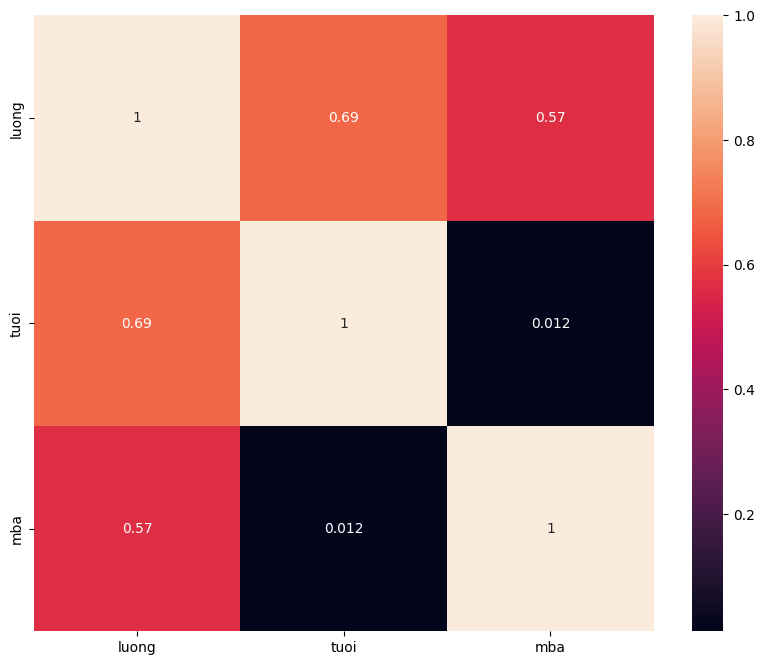

In [41]:
# Calculate the correlation matrix
correlation_matrix = table.corr()

# Save the correlation matrix to an Excel file
correlation_matrix.to_excel('regression_with_dummy_correlation_coefficient_results.xlsx')

#Correlation Heatmap (print the correlation score each variables)
plt.figure(figsize=(10, 8))
sns.heatmap(table.corr(), fmt='.2g', annot=True)

print('Read file regression_with_dummy_correlation_coefficient_results.xlsx')

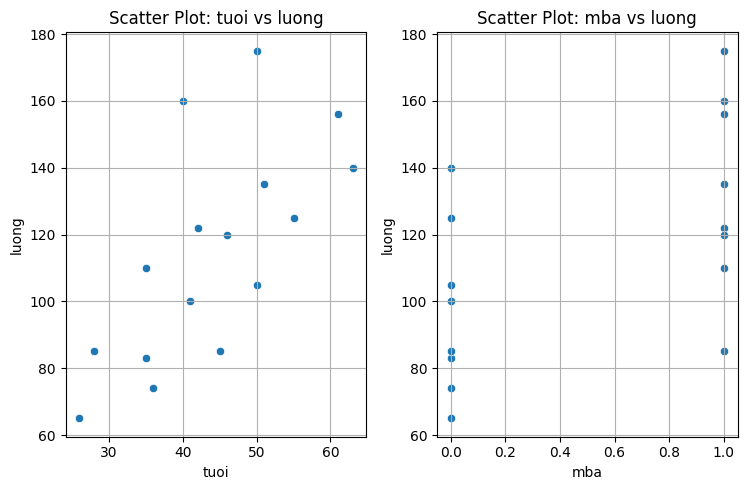

In [42]:
# Biểu đồ phân tán cho từng biến độc lập
num_plots = len(independent_vars)
cols = 4  # Number of columns in the subplot grid
rows = (num_plots + cols - 1) // cols  # Calculate the number of rows needed

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))  # Adjust figsize as needed
axes = axes.ravel()  # Flatten the axes array for easier iteration


for i, col in enumerate(independent_vars):
    sns.scatterplot(x=col, y=dependent_var, data=table, ax=axes[i])
    axes[i].set_title(f'Scatter Plot: {col} vs {dependent_var}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel(f'{dependent_var}')
    axes[i].grid(True)

# Hide any unused subplots
for j in range(i + 1, rows * cols):
    fig.delaxes(axes[j])

plt.tight_layout()  # Adjust layout to prevent overlapping titles/labels
plt.show()

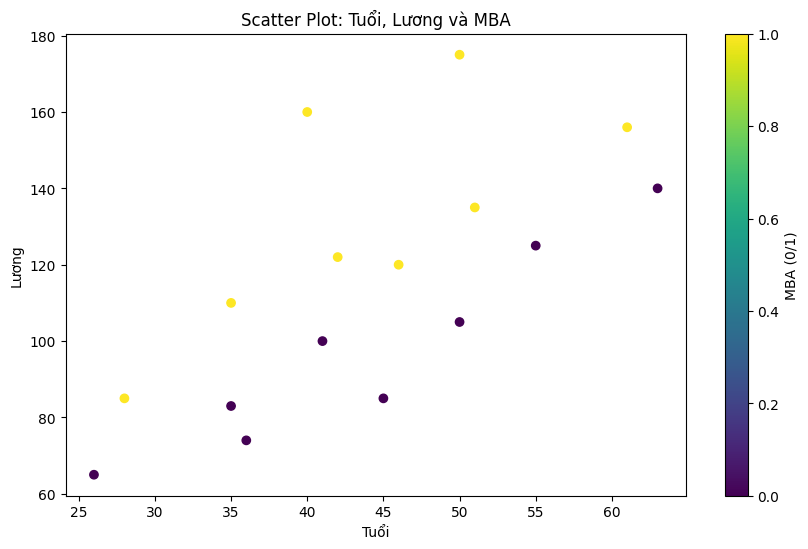

In [43]:
# Create the scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(table['tuoi'], table['luong'], c=table['mba'], cmap='viridis')

# Add labels and title
plt.xlabel('Tuổi')
plt.ylabel('Lương')
plt.title('Scatter Plot: Tuổi, Lương và MBA')

# Add a colorbar to represent the 'mba' variable
plt.colorbar(scatter, label='MBA (0/1)')

# Show the plot
plt.show()

## 4.4.4 Regression with Dummy Variables

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  res = hypotest_fun_out(*samples, **kwds)


                            OLS Regression Results                            
Dep. Variable:                  luong   R-squared:                       0.783
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     23.50
Date:                Sat, 11 Jan 2025   Prob (F-statistic):           4.82e-05
Time:                        06:21:54   Log-Likelihood:                -65.660
No. Observations:                  16   AIC:                             137.3
Df Residuals:                      13   BIC:                             139.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.9744     18.080      0.386      0.7

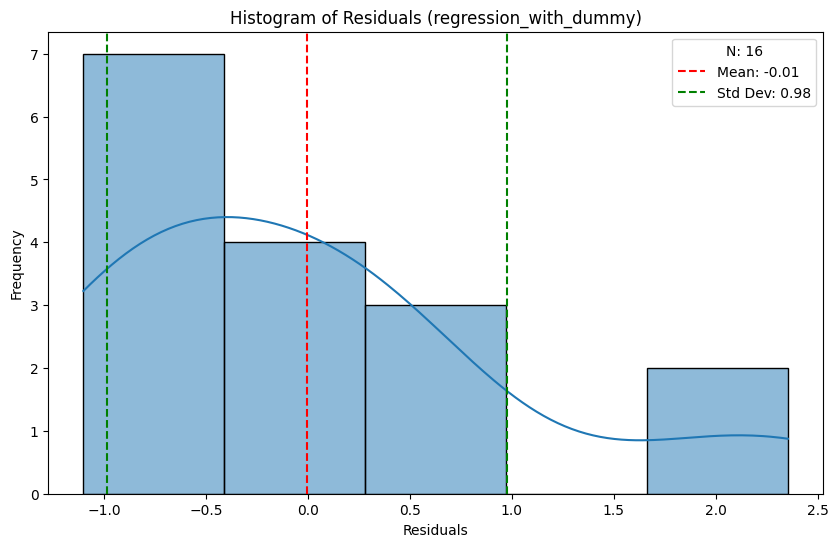

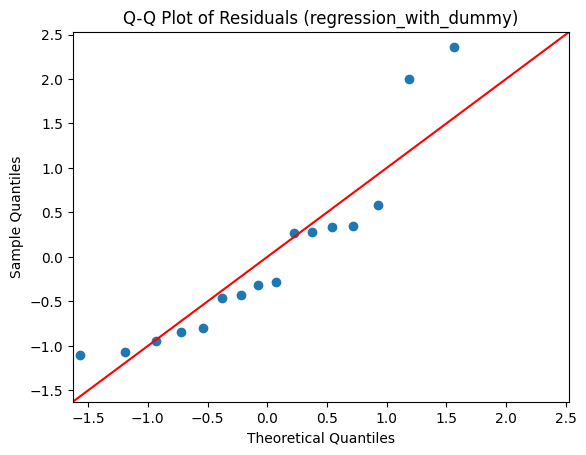

Read file regression_with_dummy_results.xlsx


In [44]:
# Tạo mô hình hồi quy tuyến tính bội sử dụng công thức
# Create the formula for the regression model
formula = f"{dependent_var} ~ {' + '.join(independent_vars)}"
# Create the multiple linear regression model using the formula
model_dummy = smf.ols(formula, data=table).fit()
print(model_dummy.summary())
print()

# Kiểm định Durbin-Watson
residuals_dummy = model_dummy.resid
durbin_watson_dummy = sm.stats.stattools.durbin_watson(residuals_dummy)

# Redesign the model_summary table
model_summary_dummy = pd.DataFrame({
  'Date': [model_dummy.summary2().tables[0].iloc[2, 1]],
  'Model': ['OLS'],
  'Dependent Variable': [model_dummy.summary2().tables[0].iloc[1, 1]],
  'R-squared': [model_dummy.rsquared],
  'Adj. R-squared': [model_dummy.rsquared_adj],
  'Durbin Watson': [durbin_watson_dummy]
})
print('Model Summary:')
print(model_summary_dummy)
print()

# Bảng ANOVA
anova_table_dummy = sm.stats.anova_lm(model_dummy, typ=2, robust='hc3')
# Calculate total sum of squares
total_sum_squares = sum((table[dependent_var] - table[dependent_var].mean())**2)
# Calculate regression sum of squares
regression_sum_squares = total_sum_squares - anova_table_dummy['sum_sq']['Residual']
# Degrees of freedom
df_regression = model_dummy.summary().tables[0][6][1].data
df_residual = model_dummy.summary().tables[0][7][1].data
df_total = pd.to_numeric(df_regression, errors='coerce') + pd.to_numeric(df_residual, errors='coerce')
# F-statistic and p-value
f_statistic = pd.to_numeric(model_dummy.summary().tables[0][2][3].data, errors='coerce')
p_value = pd.to_numeric(model_dummy.summary().tables[0][3][3].data, errors='coerce')
# Create the ANOVA table
anova_table_dummy = pd.DataFrame({
  'Source': ['Regression', 'Residual', 'Total'],
  'sum_sq': [regression_sum_squares, anova_table_dummy['sum_sq']['Residual'], total_sum_squares],
  'df': [df_regression, df_residual, df_total],
  'F': [f_statistic, None, None],
  'PR(>F)': [p_value, None, None]
})
print('ANOVA Table:')
print(anova_table_dummy)
print()

# Bảng Coefficients
coefficients_dummy = model_dummy.summary2().tables[1]
# Calculate the standardized coefficients (beta)
standardized_coefficients = model_dummy.params * (table[independent_vars].std() / table[dependent_var].std())
# Add the standardized coefficients to the coefficients table
coefficients_dummy['Standardized Coef.'] = standardized_coefficients
# Calculate VIF for each independent variable
vif_data = pd.DataFrame()
vif_data["Variable"] = independent_vars
vif_data["VIF"] = [variance_inflation_factor(table[independent_vars].values, i) for i in range(len(independent_vars))]
# Add the VIP column to the coefficients_dummy dataframe
coefficients_dummy = coefficients_dummy.merge(vif_data, how='left', left_index=True, right_on='Variable')
# Rearrange the columns
coefficients_dummy = coefficients_dummy[['Variable', 'Coef.', 'Std.Err.', 'Standardized Coef.', 't', 'P>|t|', '[0.025', '0.975]', 'VIF']]
print('Coefficients:')
print(coefficients_dummy)
print()

# Đánh giá Adj. R-squared
adj_r_squared = model_dummy.rsquared_adj
adj_r_squared_result = 'Model fits well' if adj_r_squared > 0.7 else 'Model fits moderate' if 0.5 < adj_r_squared <= 0.7 else 'Model does not fit'
print('Đánh giá Adj. R-squared:')
print(adj_r_squared_result)
print()

# Kiểm định F - Kiểm tra Sig (p-value) bảng ANOVA
anova_p_value = anova_table_dummy.loc[0, 'PR(>F)']
anova_result = 'Model is significant' if anova_p_value < alpha else 'Model is not significant'
print('Kiểm định F - Kiểm tra Sig (p-value) bảng ANOVA:')
print(anova_result)
print()

# Kiểm định Durbin–Watson
durbin_watson_result = 'No autocorrelation' if 1.5 < durbin_watson_dummy < 2.5 else 'Autocorrelation present'
print('Kiểm định Durbin–Watson:')
print(durbin_watson_result)
print()

# Kiểm định t (student) - Kiểm tra Sig (p-value) từng biến độc lập bảng Coefficients
coefficients_p_values = coefficients_dummy['P>|t|']
# Check the significance of each independent variable excluding 'Intercept'
significant_vars = coefficients_dummy[(coefficients_dummy['P>|t|'] < alpha) & (coefficients_dummy['Variable'] != 'Intercept')]
non_significant_vars = coefficients_dummy[(coefficients_dummy['P>|t|'] >= alpha) & (coefficients_dummy['Variable'] != 'Intercept')]
if significant_vars is None and non_significant_vars is not None:
  result_t_test = f"Non-significant variables: {', '.join(non_significant_vars['Variable'].dropna())}"
elif significant_vars is not None and non_significant_vars is None:
  result_t_test = f"Significant variables: {', '.join(significant_vars['Variable'].dropna())}"
else:
  result_t_test = f"Significant variables: {', '.join(significant_vars['Variable'].dropna())} AND Non-significant variables: {', '.join(non_significant_vars['Variable'].dropna())}"
print('Kiểm định t (student):')
print(result_t_test)
print()

# Check for multicollinearity using VIF
multicollinearity_vars = vif_data[vif_data['VIF'] > 10]
if not multicollinearity_vars.empty:
  multicollinearity_result = "There is a possibility of multicollinearity"
else:
  multicollinearity_result = "The model is suitable as all variables meet the VIF criteria"
print('Đánh giá hiện tượng đa cộng tuyến')
print(multicollinearity_result)
print()

# Predict the values using the regression model
predicted_values = model_dummy.predict(table) # Prediction using model_dummy
# Add the predicted values to the dataframe
table['predicted_values'] = predicted_values # Adding the column to 'table'
# Calculate MSE using NumPy
mse = np.mean((table[dependent_var] - table['predicted_values'])**2)
# Calculate RMSE
rmse = np.sqrt(mse)
# Evaluate MSE and RMSE
if mse < 10 : # example threshold, adjust as needed
  mse = "The model's Mean Squared Error (MSE) is relatively low, suggesting good fit."
else:
  mse = "The model's Mean Squared Error (MSE) is high, indicating poor fit. Consider model improvement."
if rmse < 3: # example threshold, adjust as needed
  rmse = "The model's Root Mean Squared Error is relatively low, suggesting accurate predictions."
else:
  rmse = "The model's Root Mean Squared Error is high, suggesting inaccurate predictions. Consider model improvement."
print('Đánh giá MSE và RMSE:')
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print()

# Kiểm tra nếu có điểm nào không đạt yêu cầu
if adj_r_squared_result != 'Model fits well' or anova_result != 'Model is significant' or durbin_watson_result != 'No autocorrelation' or multicollinearity_result != 'The model is suitable as all variables meet the VIF criteria' or {', '.join(non_significant_vars['Variable'].dropna())} == '' in result_t_test:
  conclusion = "Should Optimized Model"
else:
  conclusion = "Model Meets Requirements"
print('Đánh giá tổng hợp:')
print(conclusion)
print()

# Tạo bảng hypothesis_test
hypothesis_test = pd.DataFrame({
  'Đánh giá Adj. R-squared': [f'Adjusted R-squared: {adj_r_squared:.3f}, Result: {adj_r_squared_result}'],
  'Kiểm định F': [f'ANOVA p-value: {anova_p_value:.3e}, Result: {anova_result}'],
  'Kiểm định t (student)': [result_t_test],
  'Kiểm định Durbin-Watson': [f'Durbin-Watson: {durbin_watson_dummy:.3f}, Result: {durbin_watson_result}'],
  'Kiểm định VIP': [multicollinearity_result],
  'mse': [mse],
  'rmse': [rmse],
  'Conclusion': [conclusion]
})
hypothesis_test = hypothesis_test.melt(var_name='Test', value_name='Result')

# Viết phương trình hồi quy
intercept = coefficients_dummy.loc[coefficients_dummy['Variable'] == 'Intercept', 'Coef.'].values[0]
slopes = coefficients_dummy.loc[coefficients_dummy['Variable'] != 'Intercept', ['Variable', 'Coef.']]
regression_equation = f'y = {intercept:.2f}'
for index, row in slopes.iterrows():
  regression_equation += f' + {row["Coef."]:.2f} * {row["Variable"]}'
  regression_equation = f'y = {intercept:.2f}'
  for index, row in slopes.iterrows():
    coef = row["Coef."]
    variable = row["Variable"]
    sign = '+' if coef >= 0 else '-'
    regression_equation += f' {sign} {abs(coef):.2f} * {variable}'
print('Regression Equation:')
print(regression_equation)
print()

# Tạo bảng phương trình hồi quy
regression_equation_df = pd.DataFrame({
  'Function': [regression_equation],
  'Conclusion': [conclusion]
})

# Biểu đồ Histogram để khảo sát phân phối của phần dư
standardized_residuals_dummy = model_dummy.get_influence().resid_studentized_internal
mean_residuals_dummy = standardized_residuals_dummy.mean()
std_dev_residuals_dummy = standardized_residuals_dummy.std()
N_residuals_dummy = len(standardized_residuals_dummy)
plt.figure(figsize=(10, 6))
sns.histplot(standardized_residuals_dummy, kde=True)
plt.title('Histogram of Residuals (regression_with_dummy)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.axvline(mean_residuals_dummy, color='r', linestyle='--', label=f'Mean: {mean_residuals_dummy:.2f}')
plt.axvline(mean_residuals_dummy + std_dev_residuals_dummy, color='g', linestyle='--', label=f'Std Dev: {std_dev_residuals_dummy:.2f}')
plt.axvline(mean_residuals_dummy - std_dev_residuals_dummy, color='g', linestyle='--')
plt.legend(title=f'N: {N_residuals_dummy}')
plt.savefig('histogram_of_residuals_dummy.png')
plt.show()
print()

# Biểu đồ Q-Q plot để khảo sát phân phối của phần dư
sm.qqplot(standardized_residuals_dummy, line='45')
plt.title('Q-Q Plot of Residuals (regression_with_dummy)')
plt.savefig('qq_plot_of_residuals_dummy.png')
plt.show()

# Lưu kết quả vào file Excel
with pd.ExcelWriter('regression_with_dummy_results.xlsx') as writer:
  correlation_matrix.to_excel(writer, sheet_name='Corr Matrix')
  model_summary_dummy.to_excel(writer, sheet_name='Model Summary')
  anova_table_dummy.to_excel(writer, sheet_name='ANOVA')
  coefficients_dummy.to_excel(writer, sheet_name='Coefficients')
  hypothesis_test.to_excel(writer, sheet_name='Hypothesis Test', index=False)
  regression_equation_df.to_excel(writer, sheet_name='Regression Equation', index=False)
  # Access the XlsxWriter workbook and worksheet objects
  workbook  = writer.book
  worksheet = workbook.add_worksheet('Residuals Plots')

  # Insert the images into the worksheet
  worksheet.insert_image('A1', 'histogram_of_residuals_dummy.png')
  worksheet.insert_image('A10', 'qq_plot_of_residuals_dummy.png')

print('Read file regression_with_dummy_results.xlsx')

## 4.4.5 Predict the values using the regression model


In [45]:
# Predict the values using the regression model
predicted_values = model_dummy.predict(table)

# Add the predicted values to the dataframe
table['predicted_values'] = predicted_values

# Get the column names of independent variables from the model
independent_vars = list(model_dummy.params.index)
independent_vars.remove('Intercept')

# Construct the column list for display, dynamically adding independent variable names
columns_to_display = independent_vars + ['predicted_values']
table[columns_to_display]
print(table)

# Example prediction for new data
# Define the value of independent variables for which you want to predict the dependent variable
new_data = pd.DataFrame({'tuoi': [35], 'mba': [1]})
# Predict the dependent variable value using the regression model
predicted_ttxang = model_dummy.predict(new_data)
# Display the predicted value
print(f'Predicted for tuoi=35, mba=1: {predicted_ttxang.iloc[0]}')

    luong  tuoi  mba  predicted_values
0      65    26    0         60.396997
1      85    28    1         99.742746
2      74    36    0         80.944132
3      83    35    0         78.889418
4     110    35    1        114.125740
5     160    40    1        124.399307
6     100    41    0         91.217699
7     122    42    1        128.508734
8      85    45    0         99.436553
9     120    46    1        136.727588
10    105    50    0        109.710120
11    135    51    1        147.001155
12    125    55    0        119.983687
13    175    50    1        144.946441
14    156    61    1        167.548289
15    140    63    0        136.421395
Predicted for tuoi=35, mba=1: 114.12573985852457


# 4.5 Binary Logistic Regression
Binary Logistic Regression is a statistical method used to model the relationship between one or more independent variables (predictors) and a binary dependent variable (outcome). The binary outcome typically has two categories, such as “yes” or “no,” “success” or “failure,” or “0” and “1.”
```
Function:
```
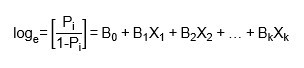
```
Predictive function model equation:
```
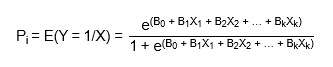

## 4.5.1 Input Data

In [46]:
# File path to your .sav file
file_path = "/content/drive/My Drive/Colab Notebooks/Data/Binary logistic.csv"

# Read the SPSS file
binary_logistic_table = pd.read_csv(file_path).drop(columns=['sothutu'])

Data on the debt recovery ability of poverty reduction programs. The problem we are interested in is predicting who should be lent to and who should not be lent to.

* Independent variable: y - pay off debt. 0 - no, 1 - yes
* Dependent variable:
  - hocvan - education level (grades 1 to 12)
  - thoigian - Length of residence in the area (month)

## 4.5.2 Input Test Value

In [47]:
# Input Data
table = binary_logistic_table
# Input the dependent variable
dependent_var = 'y'

# Define the independent variables
independent_vars = table.columns.drop(dependent_var).tolist()
# Define the confidence interval
confidence_interval = 0.95
z_value = norm.ppf((1 + confidence_interval) / 2)
alpha = round(1 - confidence_interval, 3)

## 4.5.3 Correlation Coefficient

<Axes: >

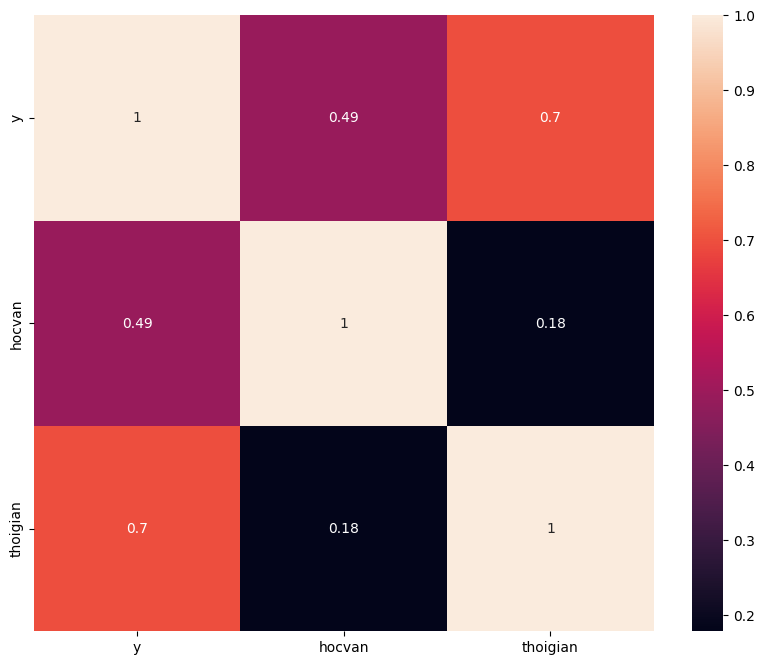

In [48]:
# Calculate the correlation matrix
correlation_matrix = table.corr()

#Correlation Heatmap (print the correlation score each variables)
plt.figure(figsize=(10, 8))
sns.heatmap(table.corr(), fmt='.2g', annot=True)

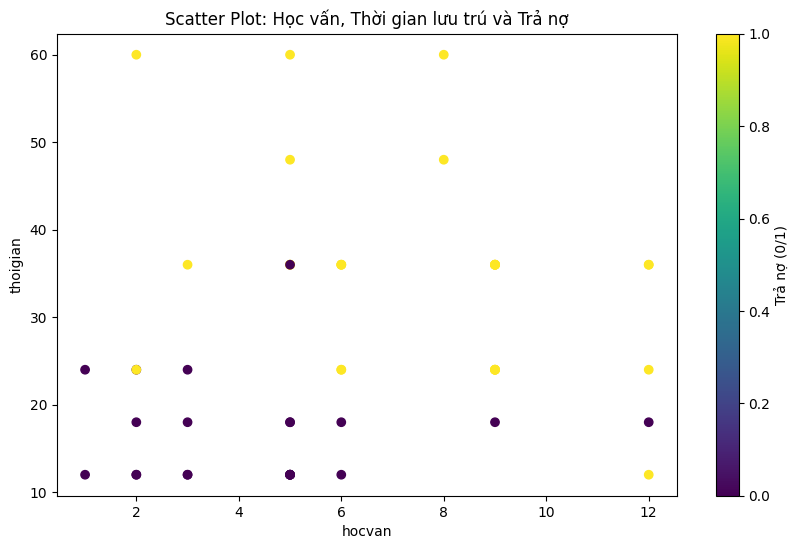

In [49]:
# Create the scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(table['hocvan'], table['thoigian'], c=table['y'], cmap='viridis')

# Add labels and title
plt.xlabel('hocvan')
plt.ylabel('thoigian')
plt.title('Scatter Plot: Học vấn, Thời gian lưu trú và Trả nợ')

# Add a colorbar to represent the 'mba' variable
plt.colorbar(scatter, label='Trả nợ (0/1)')

# Show the plot
plt.show()

## 4.5.4 Binary Logistic Regression

Optimization terminated successfully.
         Current function value: 0.234724
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   50
Model:                          Logit   Df Residuals:                       47
Method:                           MLE   Df Model:                            2
Date:                Sat, 11 Jan 2025   Pseudo R-squ.:                  0.6578
Time:                        06:21:58   Log-Likelihood:                -11.736
converged:                       True   LL-Null:                       -34.296
Covariance Type:            nonrobust   LLR p-value:                 1.593e-10
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -9.0030      2.556     -3.522      0.000     -14.013      -3.993
hocvan         0.4497      0.

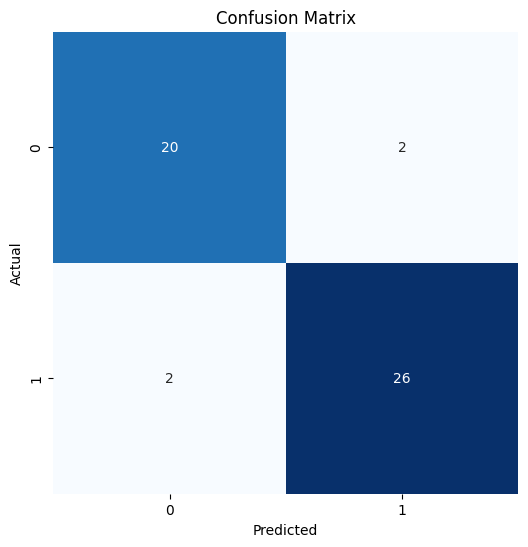

[[20  2]
 [ 2 26]]


Classification Report
              precision    recall  f1-score   support

           0       0.91      0.91      0.91        22
           1       0.93      0.93      0.93        28

    accuracy                           0.92        50
   macro avg       0.92      0.92      0.92        50
weighted avg       0.92      0.92      0.92        50



ROC AUC: 0.9675


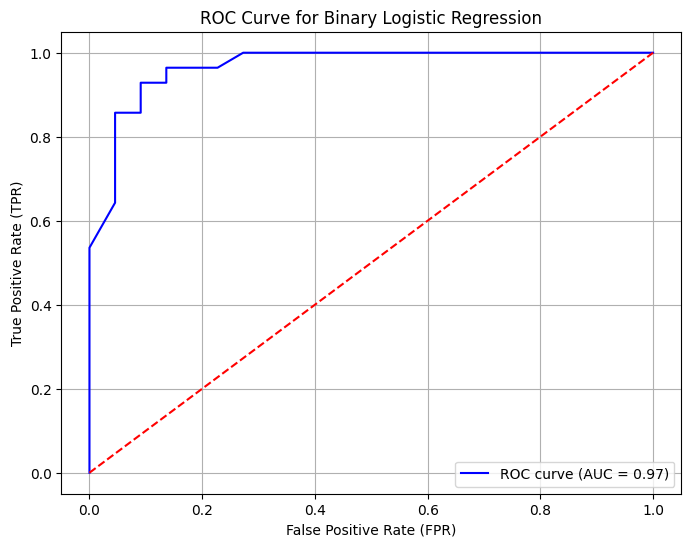

Read file binary_logistic_regression_results.xlsx


In [50]:
formula=f"{dependent_var} ~ {' + '.join(independent_vars)}"
# Fit the binary logistic regression model using the 'method' argument
logit_model = smf.logit(formula, data=table).fit()

# Print the regression results
print(logit_model.summary())
print()

# Omnibus Test of Model Coefficients
ll_full = logit_model.llf  # Log-Likelihood of full model
ll_null = logit_model.llnull  # Log-Likelihood of null model
chi2_omnibus = -2 * (ll_null - ll_full)
df_omnibus = X.shape[1] - 1  # Degrees of freedom
p_value_omnibus = chi2.sf(chi2_omnibus, df_omnibus)
omnibus_test_of_model_coefficients = pd.DataFrame({
  'Chi-square': [f'{chi2_omnibus:.4f}'],
  'Degrees of Freedom': [f'{df_omnibus}'],
  'P-value': [f'{p_value_omnibus:.4e}']
})
print("Omnibus Test of Model Coefficients")
print(omnibus_test_of_model_coefficients)
print()

# Model Summay
pseudo_r2 = 1 - (ll_full / ll_null) # Pseudo R-squared (McFadden)
model_summary = pd.DataFrame({
  'Pseudo R-squared (McFadden)': [f'{pseudo_r2:.4f}'],
  'Likelihood Ratio Test (LLR p-value)': [f'{logit_model.llr_pvalue}']
})
print('Model Summary:')
print(model_summary)
print()

# Wald Test for each variable
print("Wald Test for Variables")
wald_test_for_each_variable = pd.DataFrame({
  'Wald Test for each variable': [logit_model.summary2().tables[1]] # Displays coefficients, p-values, etc.
})
print(wald_test_for_each_variable)
print()

print('Kiểm định Chi-Square:') #Kiểm định độ phù hợp tổng quát của mô hình
if p_value_omnibus < 0.05:
  p_value_omnibus_result = "The model is statistically significant (p < 0.05)."
else:
  p_value_omnibus_result = "The model is not statistically significant (p >= 0.05)."
chi_square_test = pd.DataFrame({
  'p_value_omnibus': [p_value_omnibus], # Displays coefficients, p-values, etc.
  'p_value_omnibus_result': [p_value_omnibus_result]
})
print(chi_square_test)
print()

print('Kiểm định Pseudo R-squared:')
if pseudo_r2 > 0.2:
  pseudo_r2_result = "Pseudo R-squared indicates a reasonable fit."
else:
  pseudo_r2_result = "Pseudo R-squared indicates a weak fit."
pseudo_r_squared = pd.DataFrame({
  'pseudo_r2': [pseudo_r2], # Displays coefficients, p-values, etc.
  'pseudo_r2_result': [pseudo_r2_result]
})
print(pseudo_r_squared)
print()

print('Kiểm định Likelihood Ratio Test (LLR p-value):')
if logit_model.llr_pvalue < 0.05:
  pvalue_llr_result = "The model is statistically significant (p < 0.05)."
else:
  pvalue_llr_result = "The model is not statistically significant (p >= 0.05)."
pvalue_llr = pd.DataFrame({
  'llr_pvalue': [logit_model.llr_pvalue],
  'pvalue_llr_result': [pvalue_llr_result]
})
print(pvalue_llr)
print()

print('Kiểm định Wald về ý nghĩa của các hệ số hồi quy:')
wald_test_results = logit_model.summary2().tables[1]
significant_vars = []
non_significant_vars = []
for var, p_value in zip(independent_vars, wald_test_results['P>|z|']):
    if p_value < alpha:
        significant_vars.append(var)
    else:
        non_significant_vars.append(var)
wald_test_results = pd.DataFrame({
  'wald_test_result': [f'Significant variables: {", ".join(significant_vars)} AND Non-significant variables: {", ".join(non_significant_vars)}']
})
print(wald_test_results)
print()

# Kiểm tra nếu có điểm nào không đạt yêu cầu
if p_value_omnibus_result != 'The model is statistically significant (p < 0.05).' or pseudo_r2_result != "Pseudo R-squared indicates a reasonable fit." or pvalue_llr_result != "The model is statistically significant (p < 0.05)." or f'{", ".join(non_significant_vars)}' != '':
  conclusion = "Should Optimized Model"
else:
  conclusion = "Model Meets Requirements"
print('Đánh giá tổng hợp:')
print(conclusion)
print()

# Tạo bảng hypothesis_test
hypothesis_test = pd.DataFrame({
  'Kiểm định Chi-Square': [p_value_omnibus_result],
  'Kiểm định Pseudo R-squared': [pseudo_r2_result],
  'Kiểm định Likelihood Ratio Test (LLR p-value)': [pvalue_llr_result],
  'Kiểm định Wald về ý nghĩa của các hệ số hồi quy': [wald_test_results],
  'Conclusion': [conclusion]
})
hypothesis_test = hypothesis_test.melt(var_name='Test', value_name='Result')

# Lấy hệ số từ mô hình
coefficients = logit_model.params
# Phương trình hồi quy
terms = []
for var, coef in coefficients.items():
    if var == 'intercept':
        terms.append(f"{coef:.4f}")
    else:
        terms.append(f"{coef:.4f} * {var}")

equation = "log(p / (1 - p)) = " + " + ".join(terms)
equation_fuction = pd.DataFrame({
  'equation': [equation]
})
print("Phương trình hồi quy logistic:")
print(equation)
print()

# Confusion Matrix and Classification Report
threshold = 0.5
predictions = (logit_model.predict(table[independent_vars]) >= threshold).astype(int)
conf_matrix = confusion_matrix(table[dependent_var], predictions)
print("Confusion Matrix")
# Generate classification plot
y_pred = logit_model.predict(table[independent_vars])
y_pred_class = [1 if prob >= 0.5 else 0 for prob in y_pred]
cm = confusion_matrix(table[dependent_var], y_pred_class)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
print(conf_matrix)
print()

print("\nClassification Report")
print(classification_report(table[dependent_var], predictions))
print()

# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(table[dependent_var], logit_model.predict(table[independent_vars]))
roc_auc = auc(fpr, tpr)
print(f"\nROC AUC: {roc_auc:.4f}")
# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.title("ROC Curve for Binary Logistic Regression")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Lưu kết quả vào file Excel
with pd.ExcelWriter('binary_logistic_regression_results.xlsx') as writer:
  correlation_matrix.to_excel(writer, sheet_name='Corr Matrix')
  omnibus_test_of_model_coefficients.to_excel(writer, sheet_name='Omnibus Test')
  model_summary.to_excel(writer, sheet_name='Model Summary')
  wald_test_for_each_variable.to_excel(writer, sheet_name='Wald Test for each variable')
  chi_square_test.to_excel(writer, sheet_name='Kiểm định Chi-Square')
  pseudo_r_squared.to_excel(writer, sheet_name='Kiểm định Pseudo R-squared')
  pvalue_llr.to_excel(writer, sheet_name='Kiểm định Likelihood Ratio Test')
  wald_test_results.to_excel(writer, sheet_name='Kiểm định ý nghĩa beta')
  hypothesis_test.to_excel(writer, sheet_name='Hypothesis Test', index=False)
  equation_fuction.to_excel(writer, sheet_name='Regression Equation', index=False)
print('Read file binary_logistic_regression_results.xlsx')

## 4.4.5 Predict the values using the regression model

In [51]:
# Input values for prediction
new_data = pd.DataFrame({
    'hocvan': [9, 9],  # Example value for 'hocvan'
    'thoigian': [2, 24]  # Example value for 'thoigian'
    # Add other independent variables here
})

# Predict probabilities
probabilities = logit_model.predict(new_data)
print(f"Predicted probabilities (%):")
print(f'{probabilities*100}')
print()

# Predict classes (0 or 1) based on a threshold (e.g. 0.5)
threshold = 0.5
predicted_classes = (probabilities >= threshold).astype(int)
print(f"Predicted classes:")
print(predicted_classes)

Predicted probabilities (%):
0     1.194697
1    82.179192
dtype: float64

Predicted classes:
0    0
1    1
dtype: int64
